In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, time, os, math
import string
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import trajCellPoseSr
import h5py
import scipy
import subprocess
import umap
#from deeptime.clustering import KMeans
from csaps import csaps
from joblib import dump, load
from datetime import date

In [2]:
# Trajectory Length for morphodynamical trajectory analysis
trajl = 40
#trajl = int(sys.argv[1])
#if trajl is None:
#  print("Enter trajectory snippet length for morphodynamical analysis")
#  sys.exit(0)

#os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'

today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day
conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2',
         'OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
nRepConds = 5 # Number of models (conditions) that are replicas 
nConditions = len(tmSet) # Total number of Ligand Conditions
# Indices for the ligands = 13
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 4
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/dynaMorph']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [3]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        modelList_conditions[i] = icond
        modelName = sysName+'_'+cond+'_'+str(fov)
        # Get the name of .obj file as a "string", including its path
        modelList[i] = pathSet[imagingSet[icond]]+'/'+modelName+dateSet[imagingSet[icond]]
        #print("Model names = ", modelList[i])
        i = i + 1
    icond = icond + 1

nmodels = int(i)
indgood_models = np.array([]).astype(int)
model_objects = {}

In [4]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.joblib'
        with open(objFile, 'rb') as fp:
            # Load objects from the file 
            linSet, Xf, Xf_com, cells_frameSet, cells_indSet, Trajectories, cells_imgfileSet, cells_indcmskSet  = load(fp)
            # Assign objects of each model separately to call later by index "i" and object name
            model_objects[i] = {'linSet': linSet,
                                'Xf': Xf,
                                'Xf_com': Xf_com,
                                'cells_frameSet': cells_frameSet,
                                'cells_indSet': cells_indSet,
                                'Trajectories': Trajectories,
                                'cells_imgfileSet': cells_imgfileSet,
                                'cells_indcmskSet': cells_indcmskSet}
            print('loaded '+'.../'+objFile[32:]+' with '+str(model_objects[i]['cells_indSet'].size)+' cells')
            test = len(model_objects[i]['linSet'])
            indgood_models = np.append(indgood_models, i)
    except:
        print("Error in reading data from .joblib files")
        pass

loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A1_1.joblib with 48386 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A1_2.joblib with 73413 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A1_3.joblib with 40179 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A1_4.joblib with 50235 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A2_1.joblib with 51054 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A2_2.joblib with 97764 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A2_3.joblib with 58579 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A2_4.joblib with 58341 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A3_1.joblib with 47035 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A3_2.joblib with 68657 cells
loaded .../LI204601_INCUCYTE/segsCellPose/dynaMorph/LI204601_P_A3_3.joblib with 

In [5]:
nframes = 193 # 193 Frames -->  each of 15 mins = 48 hrs
# Create arrays for (TIFF) image files and frames (dumped @ 15 minutes) 
imgfileList = np.array([])
imgfileList = np.append(imgfileList, 0)
start_frame = 0
end_frame = nframes
imgfileSet = imgfileList.copy()
frameSet = start_frame*np.ones_like(imgfileSet)
for i in range(start_frame+1, end_frame+1):
    imgfileSet = np.append(imgfileSet, imgfileList)
    frameSet = np.append(frameSet, i*np.ones_like(imgfileList))

imgfileSet = imgfileSet.astype(int)
frameSet = frameSet.astype(int)
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [6]:
#plt.clf()
#plt.figure(figsize = (8, 7))

with open('cellNumbers.dat', 'w', encoding = 'utf-8') as fp: # PRINT cell numbers in a file for each model
    for i in indgood_models:
        ncells = np.zeros(nframes)
        ncells_smooth = np.zeros_like(ncells)
        cell_indCmskSet = np.array([]) # Array of masked cell indices
        for iS in range(nframes):
            ncells[iS] = np.sum(model_objects[i]['cells_frameSet'] == iS)
            cell_indCmskSet = np.append(cell_indCmskSet, iS*np.ones(int(ncells[iS])))
            fp.write(str(ncells[iS])+"\t")
        fp.write("\n")
        cell_indCmskSet = cell_indCmskSet.astype(int)
        model_objects[i]['cells_indcmskSet'] = cell_indCmskSet
        model_objects[i]['cells_imgfileSet'] = cell_indCmskSet
        #print("Shape of cell masks indices =", model_objects[i]['cells_indcmskSet'].shape)
        # Cubic Spline Approximation (CSAPS) to smoothen the data
        splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
        ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
        cellnumber_std = np.std(ncells[cellnumber_frames] 
                                - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
        cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers
        #print("cellnumber_stdSet[",i,"] = ", cellnumber_std)
        # Plot number of normalized number of cells vs frame number for each Model
        #plt.plot(ncells/ncells[0], color = colModels[i], label = capModels[i]);
        #plt.plot(ncells, color = colModels[i], label = capModels[i]);plt.pause(.5) 
        #plt.plot(ncells/ncells[0]); plt.pause(.5) 

#plt.xlabel('Frame Number')
#plt.ylabel('Normalized Cell Numbers')
#plt.legend(loc='best')
#plt.tight_layout()
#plt.savefig('cellNumbers_'+figid+'.png')

In [7]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
#print("Indices of high SD models = ", indhigh_std); print("Indices of good models = ", indgood_models); sys.exit(0)
print("Number of Good Models = ", len(indgood_models))

num_trajModSet = len(tmSet) # Total number of trajectory (models) conditions including replicas
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        inds_tmSet_models[i] = inds_tmSet[icond]
        inds_imagingSet_models[i] = imagingSet[icond]
        i = i + 1
    icond = icond + 1

# just replace with zeros for now? Not sure best..
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        model_objects[i]['Xf'][np.isnan(model_objects[i]['Xf'])] = 0.0

nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0, model_objects[i]['Xf_com'], axis=0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    model_objects[i]['Xf_com'][:, 0] = (model_objects[i]['Xf_com'][:, 0] - av_dx)/std_dx

nfeat = model_objects[indgood_models[0]]['Xf'].shape[1]
Xf0 = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf0 = np.append(Xf0, model_objects[i]['Xf'], axis=0)
        indtreatment = np.append(indtreatment, i*np.ones(model_objects[i]['Xf'].shape[0]))
        indcellSet = np.append(indcellSet, model_objects[i]['cells_indSet'])

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

Number of Good Models =  52


In [8]:
# we will use the sklearn package (intended for ease of use over performance/scalability)
from sklearn.decomposition import PCA 
# n_components specifies the number of principal components to extract from the covariance matrix
#pca = PCA(n_components = 3)
varCutOff = 0.99
#@@@@@@ Variance Cut Offs and their corresponding features after dimensional reduction using PCA @@@@@@
#varCutOffs = [0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.992, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
#nFeatures = [5, 6, 6, 7, 7, 8, 9, 10, 11, 13, 14, 16, 17, 20, 27]
#for varCutOff in varCutOffs:
pca = PCA(n_components = varCutOff)
# builds the covariance matrix, fit the PCs, and transforms the data into the PCA representation
Xpca = pca.fit_transform(Xf0) 
print("Number of cell features used after dimensional reduction: ",Xpca.shape[1])

Number of cell features used after dimensional reduction:  10


In [9]:
wctm = trajCellPoseSr.cellPoseTraj()  
wctm.Xpca = Xpca

for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        model_objects[i]['Xpca'] = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [ ]:
self = wctm
wctm.trajl = trajl
self.imgfileSet = imgfileSet
self.frameSet = frameSet
all_trajSet = [None]*nmodels
cells_indcmskSet = []
for i in indgood_models:
    self.trajectories = model_objects[i]['Trajectories']
    self.cells_imgfileSet = model_objects[i]['cells_imgfileSet']
    self.cells_frameSet = model_objects[i]['cells_frameSet']
    self.cells_indSet = model_objects[i]['cells_indSet']
    self.cells_indcmskSet = model_objects[i]['cells_indcmskSet']
    self.linSet = model_objects[i]['linSet']
    self.get_unique_trajectories() # Due to embedded trajectories 
    all_trajSet[i] = self.trajectories.copy()

tracked cell 48277, 10 tracks, 47500 left
tracked cell 48095, 41 tracks, 46300 left
tracked cell 47927, 41 tracks, 45700 left
tracked cell 47507, 5 tracks, 45500 left
tracked cell 47433, 6 tracks, 45400 left
tracked cell 46984, 6 tracks, 45100 left
tracked cell 46757, 40 tracks, 44900 left
tracked cell 46186, 1 tracks, 44600 left
tracked cell 45998, 8 tracks, 44500 left
tracked cell 45785, 3 tracks, 44300 left
tracked cell 45684, 9 tracks, 44200 left
tracked cell 45548, 2 tracks, 44000 left
tracked cell 45462, 11 tracks, 43900 left
tracked cell 45168, 1 tracks, 43400 left
tracked cell 45039, 6 tracks, 43300 left
tracked cell 44975, 9 tracks, 43200 left
tracked cell 44789, 36 tracks, 42500 left
tracked cell 44129, 7 tracks, 41900 left
tracked cell 43968, 6 tracks, 41800 left
tracked cell 43382, 31 tracks, 41300 left
tracked cell 42907, 3 tracks, 40800 left
tracked cell 42808, 3 tracks, 40700 left
tracked cell 41666, 60 tracks, 39500 left
tracked cell 40820, 4 tracks, 38500 left
tracked 

tracked cell 36979, 1 tracks, 34400 left
tracked cell 36743, 8 tracks, 34300 left
tracked cell 36166, 4 tracks, 34000 left
tracked cell 35251, 5 tracks, 33500 left
tracked cell 34899, 4 tracks, 33400 left
tracked cell 34442, 3 tracks, 33200 left
tracked cell 34002, 1 tracks, 33100 left
tracked cell 33682, 1 tracks, 33000 left
tracked cell 33456, 1 tracks, 32800 left
tracked cell 33352, 1 tracks, 32700 left
tracked cell 33234, 1 tracks, 32600 left
tracked cell 33112, 1 tracks, 32200 left
tracked cell 32966, 9 tracks, 31700 left
tracked cell 32042, 24 tracks, 30100 left
tracked cell 31278, 2 tracks, 29400 left
tracked cell 30411, 3 tracks, 28800 left
tracked cell 30319, 3 tracks, 28600 left
tracked cell 30177, 1 tracks, 28300 left
tracked cell 29820, 18 tracks, 28100 left
tracked cell 29302, 2 tracks, 27900 left
tracked cell 29257, 25 tracks, 27800 left
tracked cell 29074, 16 tracks, 27200 left
tracked cell 28862, 3 tracks, 27000 left
tracked cell 28529, 14 tracks, 26900 left
tracked cel

tracked cell 992, 5 tracks, 700 left
tracked cell 710, 5 tracks, 300 left
tracked cell 654, 5 tracks, 200 left
tracked cell 179, 1 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracked cell 50037, 30 tracks, 48000 left
tracked cell 50012, 52 tracks, 47600 left
tracked cell 49980, 31 tracks, 47000 left
tracked cell 49436, 6 tracks, 46100 left
tracked cell 48916, 6 tracks, 45600 left
tracked cell 48476, 1 tracks, 45100 left
tracked cell 48197, 24 tracks, 44900 left
tracked cell 48062, 26 tracks, 44600 left
tracked cell 47750, 40 tracks, 44300 left
tracked cell 47260, 42 tracks, 44000 left
tracked cell 46378, 28 tracks, 43300 left
tracked cell 45372, 5 tracks, 42800 left
tracked cell 45189, 36 tracks, 42600 left
tracked cell 44521, 2 tracks, 42200 left
tracked cell 44058, 9 tracks, 41900 left
tracked cell 43706, 30 tracks, 41300 left
tracked cell 42970, 10 tracks, 40800 left
tracked cell 42044, 3 tracks, 40300 left
tracked cell 41844, 8 tracks, 40200 left
tracked cell 41383, 1 tracks,

tracked cell 26083, 2 tracks, 25500 left
tracked cell 25803, 1 tracks, 25100 left
tracked cell 25524, 2 tracks, 24900 left
tracked cell 25187, 2 tracks, 24700 left
tracked cell 25073, 1 tracks, 24600 left
tracked cell 24594, 1 tracks, 24300 left
tracked cell 24244, 1 tracks, 23800 left
tracked cell 23645, 3 tracks, 22900 left
tracked cell 23258, 2 tracks, 22700 left
tracked cell 23034, 1 tracks, 22600 left
tracked cell 22836, 2 tracks, 22400 left
tracked cell 22741, 2 tracks, 22200 left
tracked cell 22673, 3 tracks, 22000 left
tracked cell 22440, 1 tracks, 21800 left
tracked cell 22257, 1 tracks, 21700 left
tracked cell 21940, 1 tracks, 21200 left
tracked cell 21796, 3 tracks, 21100 left
tracked cell 21167, 4 tracks, 20800 left
tracked cell 21064, 1 tracks, 20700 left
tracked cell 20940, 11 tracks, 20500 left
tracked cell 20718, 3 tracks, 20200 left
tracked cell 20668, 3 tracks, 20100 left
tracked cell 19960, 3 tracks, 19600 left
tracked cell 19859, 7 tracks, 19300 left
tracked cell 19

tracked cell 42810, 10 tracks, 39600 left
tracked cell 42580, 15 tracks, 39500 left
tracked cell 41989, 18 tracks, 39200 left
tracked cell 41866, 4 tracks, 39100 left
tracked cell 40983, 14 tracks, 38600 left
tracked cell 40770, 6 tracks, 38500 left
tracked cell 39904, 1 tracks, 38000 left
tracked cell 39488, 3 tracks, 37800 left
tracked cell 39327, 12 tracks, 37700 left
tracked cell 38243, 22 tracks, 36900 left
tracked cell 38216, 22 tracks, 36700 left
tracked cell 38077, 5 tracks, 36000 left
tracked cell 38001, 22 tracks, 35700 left
tracked cell 37915, 8 tracks, 35300 left
tracked cell 37821, 6 tracks, 35000 left
tracked cell 37584, 16 tracks, 34800 left
tracked cell 37120, 2 tracks, 34500 left
tracked cell 36775, 3 tracks, 34300 left
tracked cell 36211, 2 tracks, 34000 left
tracked cell 35821, 1 tracks, 33700 left
tracked cell 35304, 29 tracks, 33200 left
tracked cell 35176, 7 tracks, 32800 left
tracked cell 34416, 5 tracks, 31900 left
tracked cell 33629, 27 tracks, 31400 left
track

tracked cell 32965, 3 tracks, 32400 left
tracked cell 32028, 3 tracks, 31400 left
tracked cell 31337, 3 tracks, 30800 left
tracked cell 30735, 1 tracks, 30400 left
tracked cell 30452, 2 tracks, 30100 left
tracked cell 30343, 1 tracks, 29900 left
tracked cell 30118, 1 tracks, 29700 left
tracked cell 30019, 6 tracks, 29600 left
tracked cell 29936, 5 tracks, 29400 left
tracked cell 29871, 5 tracks, 29200 left
tracked cell 29337, 3 tracks, 28500 left
tracked cell 28985, 6 tracks, 28400 left
tracked cell 28323, 4 tracks, 27700 left
tracked cell 28296, 2 tracks, 27600 left
tracked cell 27757, 3 tracks, 27100 left
tracked cell 27413, 2 tracks, 27000 left
tracked cell 27083, 3 tracks, 26800 left
tracked cell 27022, 10 tracks, 26700 left
tracked cell 26762, 3 tracks, 26100 left
tracked cell 26732, 5 tracks, 26000 left
tracked cell 26634, 4 tracks, 25800 left
tracked cell 25942, 2 tracks, 25400 left
tracked cell 25875, 1 tracks, 25300 left
tracked cell 25504, 2 tracks, 25000 left
tracked cell 25

tracked cell 34776, 6 tracks, 33900 left
tracked cell 34477, 3 tracks, 33400 left
tracked cell 34355, 2 tracks, 33200 left
tracked cell 34077, 2 tracks, 33000 left
tracked cell 33696, 1 tracks, 32900 left
tracked cell 33448, 6 tracks, 32800 left
tracked cell 33331, 2 tracks, 32600 left
tracked cell 33290, 6 tracks, 32500 left
tracked cell 33249, 5 tracks, 32400 left
tracked cell 33191, 3 tracks, 32300 left
tracked cell 33137, 6 tracks, 32200 left
tracked cell 33049, 4 tracks, 32100 left
tracked cell 32276, 2 tracks, 31500 left
tracked cell 31900, 1 tracks, 31400 left
tracked cell 31694, 1 tracks, 31300 left
tracked cell 31484, 1 tracks, 31100 left
tracked cell 31201, 2 tracks, 30800 left
tracked cell 31131, 4 tracks, 30700 left
tracked cell 31080, 2 tracks, 30600 left
tracked cell 30490, 6 tracks, 29600 left
tracked cell 30293, 2 tracks, 29400 left
tracked cell 29771, 3 tracks, 29100 left
tracked cell 29700, 1 tracks, 29000 left
tracked cell 29618, 1 tracks, 28900 left
tracked cell 295

tracked cell 22454, 2 tracks, 22200 left
tracked cell 22362, 4 tracks, 22000 left
tracked cell 22305, 1 tracks, 21900 left
tracked cell 21853, 1 tracks, 21500 left
tracked cell 21547, 1 tracks, 21300 left
tracked cell 21426, 6 tracks, 21100 left
tracked cell 21365, 9 tracks, 20900 left
tracked cell 21311, 1 tracks, 20800 left
tracked cell 21224, 2 tracks, 20700 left
tracked cell 20846, 1 tracks, 20400 left
tracked cell 20574, 1 tracks, 20300 left
tracked cell 20465, 2 tracks, 20200 left
tracked cell 20372, 1 tracks, 20100 left
tracked cell 19551, 1 tracks, 19400 left
tracked cell 19452, 1 tracks, 19300 left
tracked cell 19334, 1 tracks, 19200 left
tracked cell 19128, 3 tracks, 18900 left
tracked cell 19072, 3 tracks, 18800 left
tracked cell 18947, 1 tracks, 18600 left
tracked cell 18640, 1 tracks, 18400 left
tracked cell 18477, 1 tracks, 18200 left
tracked cell 18412, 1 tracks, 18100 left
tracked cell 18340, 5 tracks, 18000 left
tracked cell 18152, 3 tracks, 17800 left
tracked cell 180

tracked cell 23280, 3 tracks, 22200 left
tracked cell 23233, 4 tracks, 22100 left
tracked cell 22677, 5 tracks, 21800 left
tracked cell 20495, 2 tracks, 19700 left
tracked cell 20254, 1 tracks, 19600 left
tracked cell 20081, 9 tracks, 19500 left
tracked cell 18801, 2 tracks, 18600 left
tracked cell 18627, 2 tracks, 18300 left
tracked cell 18542, 1 tracks, 18200 left
tracked cell 18478, 2 tracks, 18100 left
tracked cell 18206, 1 tracks, 17800 left
tracked cell 18016, 3 tracks, 17500 left
tracked cell 17847, 2 tracks, 17200 left
tracked cell 17209, 2 tracks, 16900 left
tracked cell 16867, 2 tracks, 16500 left
tracked cell 16817, 2 tracks, 16400 left
tracked cell 16768, 7 tracks, 16300 left
tracked cell 16696, 3 tracks, 16200 left
tracked cell 16598, 1 tracks, 16100 left
tracked cell 16416, 2 tracks, 16000 left
tracked cell 16162, 1 tracks, 15800 left
tracked cell 16014, 1 tracks, 15700 left
tracked cell 15852, 1 tracks, 15600 left
tracked cell 15588, 3 tracks, 15100 left
tracked cell 154

tracked cell 8429, 1 tracks, 8200 left
tracked cell 8178, 1 tracks, 7900 left
tracked cell 8071, 1 tracks, 7700 left
tracked cell 7841, 2 tracks, 7500 left
tracked cell 7504, 1 tracks, 7200 left
tracked cell 7436, 2 tracks, 7000 left
tracked cell 7271, 1 tracks, 6500 left
tracked cell 6903, 4 tracks, 6200 left
tracked cell 6612, 19 tracks, 6000 left
tracked cell 6303, 9 tracks, 5800 left
tracked cell 5975, 3 tracks, 5600 left
tracked cell 5892, 1 tracks, 5500 left
tracked cell 5628, 1 tracks, 5400 left
tracked cell 5517, 3 tracks, 5300 left
tracked cell 5429, 13 tracks, 5100 left
tracked cell 5143, 3 tracks, 4800 left
tracked cell 4896, 1 tracks, 4700 left
tracked cell 4757, 1 tracks, 4600 left
tracked cell 4657, 1 tracks, 4500 left
tracked cell 4583, 2 tracks, 4400 left
tracked cell 4493, 1 tracks, 4300 left
tracked cell 4144, 1 tracks, 4000 left
tracked cell 4021, 1 tracks, 3900 left
tracked cell 3837, 1 tracks, 3600 left
tracked cell 3689, 3 tracks, 3200 left
tracked cell 3371, 1 tr

tracked cell 40407, 2 tracks, 39500 left
tracked cell 40233, 1 tracks, 39400 left
tracked cell 40052, 4 tracks, 39300 left
tracked cell 40004, 8 tracks, 39200 left
tracked cell 39929, 4 tracks, 39000 left
tracked cell 39095, 2 tracks, 38500 left
tracked cell 38556, 2 tracks, 37700 left
tracked cell 38184, 2 tracks, 37000 left
tracked cell 37199, 5 tracks, 35400 left
tracked cell 36618, 17 tracks, 35100 left
tracked cell 36459, 2 tracks, 35000 left
tracked cell 36090, 31 tracks, 33900 left
tracked cell 36029, 6 tracks, 33300 left
tracked cell 35818, 21 tracks, 32800 left
tracked cell 35338, 3 tracks, 32300 left
tracked cell 35179, 13 tracks, 32200 left
tracked cell 34330, 7 tracks, 31800 left
tracked cell 33990, 6 tracks, 31600 left
tracked cell 31488, 2 tracks, 30300 left
tracked cell 31116, 1 tracks, 30100 left
tracked cell 31036, 9 tracks, 29800 left
tracked cell 30759, 7 tracks, 29600 left
tracked cell 30303, 5 tracks, 29400 left
tracked cell 29951, 4 tracks, 29300 left
tracked cell

tracked cell 30177, 3 tracks, 29600 left
tracked cell 30098, 3 tracks, 29300 left
tracked cell 30031, 3 tracks, 29100 left
tracked cell 29977, 1 tracks, 29000 left
tracked cell 29490, 4 tracks, 28700 left
tracked cell 28915, 12 tracks, 28300 left
tracked cell 28739, 1 tracks, 28100 left
tracked cell 28673, 3 tracks, 28000 left
tracked cell 28536, 4 tracks, 27900 left
tracked cell 28285, 1 tracks, 27800 left
tracked cell 27847, 5 tracks, 27300 left
tracked cell 27770, 2 tracks, 27200 left
tracked cell 26720, 2 tracks, 26100 left
tracked cell 25909, 5 tracks, 25500 left
tracked cell 25832, 2 tracks, 25400 left
tracked cell 25749, 1 tracks, 25300 left
tracked cell 25227, 1 tracks, 25000 left
tracked cell 24919, 3 tracks, 24700 left
tracked cell 24859, 3 tracks, 24600 left
tracked cell 24800, 2 tracks, 24500 left
tracked cell 24414, 1 tracks, 24200 left
tracked cell 24174, 1 tracks, 24000 left
tracked cell 24086, 1 tracks, 23900 left
tracked cell 24004, 1 tracks, 23800 left
tracked cell 23

tracked cell 18534, 3 tracks, 17800 left
tracked cell 18386, 1 tracks, 17700 left
tracked cell 18238, 1 tracks, 17500 left
tracked cell 18132, 2 tracks, 17400 left
tracked cell 18010, 4 tracks, 17300 left
tracked cell 17669, 2 tracks, 16800 left
tracked cell 17616, 3 tracks, 16700 left
tracked cell 17567, 3 tracks, 16600 left
tracked cell 17518, 4 tracks, 16500 left
tracked cell 17044, 6 tracks, 16000 left
tracked cell 16929, 7 tracks, 15800 left
tracked cell 16646, 1 tracks, 15400 left
tracked cell 15111, 1 tracks, 14100 left
tracked cell 14889, 2 tracks, 14000 left
tracked cell 14646, 4 tracks, 13800 left
tracked cell 14520, 1 tracks, 13700 left
tracked cell 14414, 50 tracks, 13600 left
tracked cell 14370, 1 tracks, 13500 left
tracked cell 14342, 1 tracks, 13400 left
tracked cell 14284, 1 tracks, 13100 left
tracked cell 14186, 3 tracks, 12300 left
tracked cell 14175, 3 tracks, 12200 left
tracked cell 14124, 14 tracks, 12100 left
tracked cell 14024, 4 tracks, 11800 left
tracked cell 1

tracked cell 29001, 5 tracks, 28500 left
tracked cell 28746, 1 tracks, 27900 left
tracked cell 27804, 7 tracks, 26900 left
tracked cell 27698, 1 tracks, 26400 left
tracked cell 27664, 1 tracks, 26100 left
tracked cell 27342, 5 tracks, 25500 left
tracked cell 27121, 6 tracks, 24900 left
tracked cell 26903, 17 tracks, 24800 left
tracked cell 25632, 3 tracks, 24100 left
tracked cell 25238, 2 tracks, 23700 left
tracked cell 24574, 4 tracks, 23000 left
tracked cell 23890, 12 tracks, 22800 left
tracked cell 23539, 3 tracks, 22400 left
tracked cell 23074, 4 tracks, 22100 left
tracked cell 22090, 3 tracks, 21400 left
tracked cell 21277, 7 tracks, 20800 left
tracked cell 20736, 5 tracks, 20300 left
tracked cell 20550, 1 tracks, 20100 left
tracked cell 19792, 1 tracks, 19600 left
tracked cell 19579, 1 tracks, 19500 left
tracked cell 19433, 1 tracks, 19400 left
tracked cell 19306, 13 tracks, 18300 left
tracked cell 19226, 13 tracks, 17400 left
tracked cell 19187, 7 tracks, 17000 left
tracked cell

tracked cell 798, 3 tracks, 400 left
tracked cell 659, 3 tracks, 200 left
tracked cell 571, 3 tracks, 100 left
tracked cell 9, 1 tracks, 0 left
tracked cell 49514, 5 tracks, 46700 left
tracked cell 49207, 18 tracks, 46500 left
tracked cell 49001, 18 tracks, 46400 left
tracked cell 48726, 1 tracks, 46200 left
tracked cell 48362, 16 tracks, 45900 left
tracked cell 47125, 6 tracks, 45100 left
tracked cell 46425, 6 tracks, 44600 left
tracked cell 45412, 1 tracks, 43600 left
tracked cell 44815, 4 tracks, 43200 left
tracked cell 44088, 1 tracks, 42700 left
tracked cell 43970, 15 tracks, 42600 left
tracked cell 43661, 7 tracks, 41300 left
tracked cell 43401, 21 tracks, 40800 left
tracked cell 43163, 29 tracks, 40500 left
tracked cell 42992, 5 tracks, 40400 left
tracked cell 40169, 18 tracks, 38000 left
tracked cell 39786, 17 tracks, 37400 left
tracked cell 39499, 3 tracks, 37200 left
tracked cell 38913, 12 tracks, 36900 left
tracked cell 38772, 7 tracks, 36800 left
tracked cell 37619, 9 track

tracked cell 2195, 2 tracks, 2000 left
tracked cell 2068, 2 tracks, 1900 left
tracked cell 1878, 1 tracks, 1800 left
tracked cell 1621, 8 tracks, 1200 left
tracked cell 1262, 3 tracks, 700 left
tracked cell 434, 3 tracks, 200 left
tracked cell 358, 2 tracks, 100 left
tracked cell 0, 1 tracks, 0 left
tracked cell 36563, 25 tracks, 36200 left
tracked cell 35385, 41 tracks, 34000 left
tracked cell 34608, 2 tracks, 33200 left
tracked cell 34331, 10 tracks, 32900 left
tracked cell 34273, 34 tracks, 32800 left
tracked cell 33970, 1 tracks, 31700 left
tracked cell 32974, 2 tracks, 30500 left
tracked cell 32215, 58 tracks, 30100 left
tracked cell 31230, 12 tracks, 29200 left
tracked cell 31125, 33 tracks, 29100 left
tracked cell 30817, 7 tracks, 28200 left
tracked cell 29617, 33 tracks, 27100 left
tracked cell 29051, 40 tracks, 26500 left
tracked cell 28007, 38 tracks, 25700 left
tracked cell 27866, 4 tracks, 25600 left
tracked cell 27709, 5 tracks, 25500 left
tracked cell 26932, 13 tracks, 25

tracked cell 27590, 1 tracks, 25700 left
tracked cell 27561, 13 tracks, 25600 left
tracked cell 26173, 1 tracks, 24700 left
tracked cell 25962, 2 tracks, 24600 left
tracked cell 25800, 1 tracks, 24400 left
tracked cell 25434, 18 tracks, 24200 left
tracked cell 25145, 1 tracks, 23400 left
tracked cell 25041, 5 tracks, 23300 left
tracked cell 24718, 8 tracks, 23000 left
tracked cell 24454, 6 tracks, 22900 left
tracked cell 24397, 7 tracks, 22800 left
tracked cell 23581, 1 tracks, 22400 left
tracked cell 23334, 3 tracks, 22300 left
tracked cell 22698, 1 tracks, 21800 left
tracked cell 22355, 1 tracks, 21600 left
tracked cell 22326, 12 tracks, 21500 left
tracked cell 22131, 9 tracks, 21000 left
tracked cell 21711, 14 tracks, 20200 left
tracked cell 21356, 4 tracks, 20000 left
tracked cell 21140, 5 tracks, 19800 left
tracked cell 20674, 3 tracks, 19600 left
tracked cell 19758, 1 tracks, 19100 left
tracked cell 19632, 2 tracks, 18900 left
tracked cell 19522, 3 tracks, 18800 left
tracked cell

tracked cell 11714, 1 tracks, 10900 left
tracked cell 11135, 2 tracks, 10500 left
tracked cell 10977, 20 tracks, 10400 left
tracked cell 10612, 1 tracks, 10100 left
tracked cell 10540, 1 tracks, 10000 left
tracked cell 10305, 4 tracks, 9800 left
tracked cell 10211, 1 tracks, 9700 left
tracked cell 10103, 18 tracks, 9300 left
tracked cell 10086, 3 tracks, 9200 left
tracked cell 9934, 3 tracks, 8700 left
tracked cell 9478, 6 tracks, 8500 left
tracked cell 9243, 4 tracks, 8000 left
tracked cell 9165, 4 tracks, 7500 left
tracked cell 8746, 1 tracks, 7300 left
tracked cell 7650, 8 tracks, 6300 left
tracked cell 6709, 4 tracks, 6000 left
tracked cell 5888, 3 tracks, 5500 left
tracked cell 5758, 2 tracks, 5200 left
tracked cell 5631, 2 tracks, 5000 left
tracked cell 4690, 4 tracks, 4100 left
tracked cell 4138, 1 tracks, 3700 left
tracked cell 3998, 2 tracks, 3500 left
tracked cell 3663, 13 tracks, 3100 left
tracked cell 3624, 1 tracks, 3000 left
tracked cell 3234, 11 tracks, 1600 left
tracked

tracked cell 40471, 2 tracks, 39600 left
tracked cell 40272, 1 tracks, 39500 left
tracked cell 40025, 3 tracks, 39400 left
tracked cell 39428, 1 tracks, 38800 left
tracked cell 39225, 2 tracks, 38700 left
tracked cell 39105, 3 tracks, 38600 left
tracked cell 38904, 2 tracks, 38200 left
tracked cell 38874, 6 tracks, 38100 left
tracked cell 38829, 2 tracks, 38000 left
tracked cell 38654, 4 tracks, 37700 left
tracked cell 38389, 1 tracks, 37500 left
tracked cell 38234, 1 tracks, 37400 left
tracked cell 37917, 2 tracks, 37000 left
tracked cell 37822, 3 tracks, 36800 left
tracked cell 37106, 3 tracks, 36200 left
tracked cell 37072, 8 tracks, 36100 left
tracked cell 36527, 1 tracks, 35700 left
tracked cell 36444, 2 tracks, 35600 left
tracked cell 35974, 4 tracks, 35200 left
tracked cell 35856, 2 tracks, 35000 left
tracked cell 35700, 1 tracks, 34700 left
tracked cell 35390, 4 tracks, 34400 left
tracked cell 34905, 2 tracks, 34000 left
tracked cell 34640, 1 tracks, 33900 left
tracked cell 343

tracked cell 91774, 2 tracks, 81100 left
tracked cell 91490, 19 tracks, 80700 left
tracked cell 90671, 1 tracks, 80000 left
tracked cell 90578, 10 tracks, 79900 left
tracked cell 89918, 3 tracks, 79300 left
tracked cell 89760, 10 tracks, 79100 left
tracked cell 89314, 5 tracks, 78800 left
tracked cell 88822, 13 tracks, 78500 left
tracked cell 88176, 5 tracks, 78000 left
tracked cell 87494, 5 tracks, 77400 left
tracked cell 87331, 2 tracks, 77300 left
tracked cell 86925, 40 tracks, 77000 left
tracked cell 86720, 2 tracks, 76800 left
tracked cell 86260, 33 tracks, 76400 left
tracked cell 85982, 40 tracks, 76000 left
tracked cell 85879, 5 tracks, 75900 left
tracked cell 85767, 19 tracks, 75700 left
tracked cell 85363, 31 tracks, 75400 left
tracked cell 85084, 4 tracks, 75200 left
tracked cell 84368, 42 tracks, 74700 left
tracked cell 84126, 40 tracks, 74500 left
tracked cell 83059, 19 tracks, 73700 left
tracked cell 82681, 1 tracks, 73300 left
tracked cell 82204, 94 tracks, 72900 left
tra

tracked cell 6732, 1 tracks, 5900 left
tracked cell 6325, 1 tracks, 5700 left
tracked cell 6219, 1 tracks, 5600 left
tracked cell 6074, 8 tracks, 5500 left
tracked cell 6034, 6 tracks, 5300 left
tracked cell 5978, 5 tracks, 5100 left
tracked cell 5943, 1 tracks, 5000 left
tracked cell 5742, 1 tracks, 4700 left
tracked cell 5417, 3 tracks, 4400 left
tracked cell 5241, 2 tracks, 4300 left
tracked cell 5132, 11 tracks, 4200 left
tracked cell 4365, 1 tracks, 3500 left
tracked cell 4125, 2 tracks, 3300 left
tracked cell 3912, 4 tracks, 3200 left
tracked cell 3661, 1 tracks, 3100 left
tracked cell 3123, 2 tracks, 2700 left
tracked cell 2462, 4 tracks, 2000 left
tracked cell 1981, 3 tracks, 1300 left
tracked cell 1548, 3 tracks, 1200 left
tracked cell 1365, 1 tracks, 1100 left
tracked cell 1142, 2 tracks, 1000 left
tracked cell 1062, 1 tracks, 900 left
tracked cell 953, 1 tracks, 800 left
tracked cell 761, 2 tracks, 500 left
tracked cell 687, 2 tracks, 400 left
tracked cell 627, 3 tracks, 300

tracked cell 12388, 1 tracks, 12100 left
tracked cell 12246, 2 tracks, 12000 left
tracked cell 12064, 2 tracks, 11700 left
tracked cell 11759, 1 tracks, 11500 left
tracked cell 11606, 1 tracks, 11400 left
tracked cell 11459, 1 tracks, 11300 left
tracked cell 11324, 1 tracks, 11200 left
tracked cell 11153, 1 tracks, 11000 left
tracked cell 10903, 1 tracks, 10800 left
tracked cell 10809, 1 tracks, 10700 left
tracked cell 10705, 1 tracks, 10600 left
tracked cell 10613, 2 tracks, 10500 left
tracked cell 10515, 2 tracks, 10400 left
tracked cell 10397, 1 tracks, 10300 left
tracked cell 10175, 2 tracks, 10000 left
tracked cell 10095, 2 tracks, 9900 left
tracked cell 9529, 1 tracks, 9300 left
tracked cell 9364, 1 tracks, 9200 left
tracked cell 9260, 1 tracks, 9100 left
tracked cell 9121, 1 tracks, 9000 left
tracked cell 8951, 2 tracks, 8800 left
tracked cell 8887, 2 tracks, 8700 left
tracked cell 8552, 2 tracks, 8400 left
tracked cell 8484, 1 tracks, 8300 left
tracked cell 8247, 2 tracks, 8000

tracked cell 3560, 29 tracks, 3200 left
tracked cell 3336, 5 tracks, 2900 left
tracked cell 3157, 8 tracks, 2800 left
tracked cell 2435, 1 tracks, 2200 left
tracked cell 2246, 3 tracks, 1800 left
tracked cell 2149, 5 tracks, 1700 left
tracked cell 1682, 4 tracks, 1200 left
tracked cell 1529, 1 tracks, 1100 left
tracked cell 1408, 2 tracks, 1000 left
tracked cell 1229, 9 tracks, 800 left
tracked cell 637, 6 tracks, 200 left
tracked cell 4, 1 tracks, 0 left
tracked cell 54867, 52 tracks, 54400 left
tracked cell 54774, 4 tracks, 52800 left
tracked cell 54657, 66 tracks, 50100 left
tracked cell 51863, 40 tracks, 45000 left
tracked cell 51523, 5 tracks, 44700 left
tracked cell 47156, 45 tracks, 41800 left
tracked cell 46424, 23 tracks, 41400 left
tracked cell 46259, 10 tracks, 41300 left
tracked cell 43242, 32 tracks, 39900 left
tracked cell 42610, 1 tracks, 39600 left
tracked cell 42410, 11 tracks, 39500 left
tracked cell 42244, 18 tracks, 39400 left
tracked cell 41376, 1 tracks, 39000 lef

tracked cell 32073, 8 tracks, 29600 left
tracked cell 31047, 1 tracks, 29200 left
tracked cell 30778, 4 tracks, 29100 left
tracked cell 30602, 22 tracks, 29000 left
tracked cell 29759, 1 tracks, 28700 left
tracked cell 29490, 12 tracks, 28600 left
tracked cell 29285, 13 tracks, 27000 left
tracked cell 29197, 10 tracks, 26500 left
tracked cell 29137, 14 tracks, 26300 left
tracked cell 28289, 1 tracks, 25800 left
tracked cell 28173, 3 tracks, 25700 left
tracked cell 27649, 38 tracks, 25400 left
tracked cell 27207, 8 tracks, 25200 left
tracked cell 26791, 1 tracks, 25000 left
tracked cell 26604, 6 tracks, 24900 left
tracked cell 26005, 3 tracks, 24700 left
tracked cell 25428, 5 tracks, 24500 left
tracked cell 25009, 2 tracks, 24300 left
tracked cell 24665, 1 tracks, 24100 left
tracked cell 24513, 4 tracks, 23900 left
tracked cell 24390, 32 tracks, 23600 left
tracked cell 24267, 4 tracks, 23300 left
tracked cell 23875, 1 tracks, 23100 left
tracked cell 23735, 1 tracks, 23000 left
tracked c

tracked cell 13624, 1 tracks, 13500 left
tracked cell 13547, 1 tracks, 13400 left
tracked cell 13472, 1 tracks, 13300 left
tracked cell 13218, 1 tracks, 12800 left
tracked cell 12988, 2 tracks, 12700 left
tracked cell 12896, 2 tracks, 12600 left
tracked cell 12741, 1 tracks, 12500 left
tracked cell 12574, 1 tracks, 12400 left
tracked cell 12511, 3 tracks, 12300 left
tracked cell 12365, 3 tracks, 12100 left
tracked cell 12292, 2 tracks, 12000 left
tracked cell 12111, 1 tracks, 11900 left
tracked cell 11982, 1 tracks, 11800 left
tracked cell 11874, 1 tracks, 11700 left
tracked cell 11698, 2 tracks, 11200 left
tracked cell 11231, 9 tracks, 10700 left
tracked cell 10826, 1 tracks, 10500 left
tracked cell 10617, 1 tracks, 10400 left
tracked cell 10273, 1 tracks, 10000 left
tracked cell 10060, 1 tracks, 9800 left
tracked cell 9847, 3 tracks, 9600 left
tracked cell 9585, 2 tracks, 9400 left
tracked cell 9461, 1 tracks, 9300 left
tracked cell 9344, 1 tracks, 9200 left
tracked cell 9262, 3 trac

tracked cell 1773, 1 tracks, 1400 left
tracked cell 1571, 3 tracks, 1200 left
tracked cell 1513, 3 tracks, 1100 left
tracked cell 1466, 2 tracks, 1000 left
tracked cell 658, 3 tracks, 400 left
tracked cell 506, 4 tracks, 300 left
tracked cell 244, 2 tracks, 100 left
tracked cell 1, 1 tracks, 0 left
tracked cell 46456, 23 tracks, 45000 left
tracked cell 45217, 5 tracks, 43900 left
tracked cell 44973, 14 tracks, 43700 left
tracked cell 44699, 21 tracks, 43600 left
tracked cell 44140, 1 tracks, 43400 left
tracked cell 43950, 2 tracks, 42900 left
tracked cell 43889, 18 tracks, 42800 left
tracked cell 42740, 14 tracks, 41600 left
tracked cell 42346, 1 tracks, 41500 left
tracked cell 42053, 6 tracks, 41200 left
tracked cell 41861, 4 tracks, 41000 left
tracked cell 41623, 2 tracks, 40800 left
tracked cell 41511, 3 tracks, 40700 left
tracked cell 41333, 1 tracks, 40600 left
tracked cell 41126, 1 tracks, 40500 left
tracked cell 40723, 6 tracks, 38500 left
tracked cell 40057, 18 tracks, 38000 le

tracked cell 38570, 14 tracks, 37700 left
tracked cell 38037, 1 tracks, 36500 left
tracked cell 37872, 10 tracks, 36400 left
tracked cell 37252, 10 tracks, 35800 left
tracked cell 37197, 10 tracks, 35700 left
tracked cell 36386, 2 tracks, 35300 left
tracked cell 34793, 1 tracks, 34400 left
tracked cell 34630, 5 tracks, 34300 left
tracked cell 34461, 1 tracks, 34100 left
tracked cell 34392, 1 tracks, 34000 left
tracked cell 34270, 2 tracks, 33800 left
tracked cell 33873, 7 tracks, 33100 left
tracked cell 33711, 35 tracks, 33000 left
tracked cell 33364, 1 tracks, 32800 left
tracked cell 33196, 1 tracks, 32500 left
tracked cell 33035, 2 tracks, 32300 left
tracked cell 32546, 3 tracks, 32000 left
tracked cell 32377, 1 tracks, 31800 left
tracked cell 32196, 1 tracks, 31700 left
tracked cell 32127, 3 tracks, 31600 left
tracked cell 31906, 1 tracks, 31200 left
tracked cell 31782, 1 tracks, 31100 left
tracked cell 31715, 44 tracks, 31000 left
tracked cell 31338, 4 tracks, 30100 left
tracked ce

tracked cell 6818, 10 tracks, 4800 left
tracked cell 6070, 13 tracks, 4600 left
tracked cell 5321, 6 tracks, 4300 left
tracked cell 4971, 4 tracks, 4200 left
tracked cell 4888, 11 tracks, 4000 left
tracked cell 4762, 3 tracks, 3900 left
tracked cell 4490, 2 tracks, 3700 left
tracked cell 3839, 7 tracks, 3000 left
tracked cell 3751, 9 tracks, 2800 left
tracked cell 2838, 5 tracks, 2000 left
tracked cell 2639, 1 tracks, 1900 left
tracked cell 2476, 3 tracks, 1800 left
tracked cell 2213, 1 tracks, 1700 left
tracked cell 1996, 2 tracks, 1600 left
tracked cell 1845, 6 tracks, 1400 left
tracked cell 1762, 5 tracks, 1200 left
tracked cell 1588, 7 tracks, 1000 left
tracked cell 1224, 3 tracks, 700 left
tracked cell 870, 5 tracks, 600 left
tracked cell 642, 1 tracks, 400 left
tracked cell 2, 1 tracks, 0 left
tracked cell 37963, 1 tracks, 37600 left
tracked cell 37881, 8 tracks, 37000 left
tracked cell 37814, 1 tracks, 36600 left
tracked cell 37628, 7 tracks, 36200 left
tracked cell 36259, 2 tra

tracked cell 13742, 1 tracks, 11000 left
tracked cell 12477, 9 tracks, 9600 left
tracked cell 12010, 7 tracks, 8500 left
tracked cell 11619, 1 tracks, 8400 left
tracked cell 11433, 40 tracks, 8300 left
tracked cell 10507, 40 tracks, 7900 left
tracked cell 10146, 2 tracks, 7300 left
tracked cell 8624, 3 tracks, 6500 left
tracked cell 8601, 4 tracks, 6400 left
tracked cell 7881, 2 tracks, 5800 left
tracked cell 7541, 34 tracks, 5400 left
tracked cell 6213, 14 tracks, 3500 left
tracked cell 5852, 7 tracks, 3400 left
tracked cell 5600, 26 tracks, 3200 left
tracked cell 3465, 1 tracks, 2400 left
tracked cell 3378, 1 tracks, 2300 left
tracked cell 2989, 7 tracks, 2000 left
tracked cell 2922, 1 tracks, 1900 left
tracked cell 2894, 1 tracks, 1800 left
tracked cell 1623, 1 tracks, 1000 left
tracked cell 1441, 2 tracks, 900 left
tracked cell 1375, 2 tracks, 800 left
tracked cell 1333, 5 tracks, 700 left
tracked cell 854, 1 tracks, 300 left
tracked cell 6, 1 tracks, 0 left
tracked cell 69884, 2 t

tracked cell 25601, 5 tracks, 23000 left
tracked cell 24785, 4 tracks, 22700 left
tracked cell 24576, 9 tracks, 22600 left
tracked cell 24396, 3 tracks, 22300 left
tracked cell 23858, 9 tracks, 21700 left
tracked cell 23335, 13 tracks, 21000 left
tracked cell 22988, 7 tracks, 20200 left
tracked cell 22885, 7 tracks, 19800 left
tracked cell 22001, 1 tracks, 19000 left
tracked cell 21837, 17 tracks, 18900 left
tracked cell 21235, 10 tracks, 18600 left
tracked cell 21016, 14 tracks, 18500 left
tracked cell 20803, 1 tracks, 18400 left
tracked cell 20479, 1 tracks, 18300 left
tracked cell 20393, 1 tracks, 18000 left
tracked cell 19892, 6 tracks, 17400 left
tracked cell 19022, 1 tracks, 17000 left
tracked cell 18874, 3 tracks, 16900 left
tracked cell 18756, 4 tracks, 16800 left
tracked cell 17505, 2 tracks, 15900 left
tracked cell 17176, 14 tracks, 15300 left
tracked cell 16876, 2 tracks, 15200 left
tracked cell 16732, 2 tracks, 15100 left
tracked cell 16623, 41 tracks, 15000 left
tracked ce

In [12]:
# Storing PCA'ed features at a desired trajectory snippet length, i.e., "trajl"
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print("building trajectory data for model", i ,"...")
    self.trajectories = all_trajSet[i].copy()
    model_objects[i]['Trajectories'] = self.trajectories
    model_objects[i]['trajl'] = trajl
    model_objects[i]['traj'] = self.get_traj_segments(trajl) 
    data = model_objects[i]['Xpca'][model_objects[i]['traj'], :]
    datacom = model_objects[i]['Xf_com'][model_objects[i]['traj'], :]
    data = data.reshape(model_objects[i]['traj'].shape[0], model_objects[i]['Xpca'].shape[1]*trajl)
    datacom = datacom.reshape(model_objects[i]['traj'].shape[0], model_objects[i]['Xf_com'].shape[1]*trajl)
    data = np.append(data, datacom, axis=1)
    indgood = np.where(np.sum(np.isnan(data), axis=1) == 0)[0]
    data = data[indgood, :]
    model_objects[i]['traj'] = model_objects[i]['traj'][indgood, :]
    Xpcat = np.append(Xpcat, data, axis = 0)
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0]))
    indstacks = model_objects[i]['cells_imgfileSet'][model_objects[i]['traj'][:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = model_objects[i]['cells_frameSet'][model_objects[i]['traj'][:, 0]]
    indframes_traj = np.append(indframes_traj, indframes)
    cellinds0 = model_objects[i]['traj'][:, 0]
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = model_objects[i]['traj'][:, -1]
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, model_objects[i]['Xf'][cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)
print("Shape of Xpcat: ",Xpcat.shape)

building trajectory data for model 0 ...
building trajectory data for model 1 ...
building trajectory data for model 2 ...
building trajectory data for model 3 ...
building trajectory data for model 4 ...
building trajectory data for model 5 ...
building trajectory data for model 6 ...
building trajectory data for model 7 ...
building trajectory data for model 8 ...
building trajectory data for model 9 ...
building trajectory data for model 10 ...
building trajectory data for model 11 ...
building trajectory data for model 12 ...
building trajectory data for model 13 ...
building trajectory data for model 14 ...
building trajectory data for model 15 ...
building trajectory data for model 16 ...
building trajectory data for model 17 ...
building trajectory data for model 18 ...
building trajectory data for model 19 ...
building trajectory data for model 20 ...
building trajectory data for model 21 ...
building trajectory data for model 22 ...
building trajectory data for model 23 ...
bu

In [13]:
# Apply UMAP on PCA'ed features of cell trajectories
get_embedding = False
neigen = 2
if get_embedding:
    reducer = umap.UMAP(n_neighbors = 200, min_dist = 0.1,
                        n_components = neigen, metric = 'euclidean')
    trans = reducer.fit(Xpcat)
    embedTraj_feat = trans.embedding_
    indst = np.arange(embedTraj_feat.shape[0]).astype(int)
    wctm.Xtraj = embedTraj_feat.copy()
    wctm.indst = indst.copy()
    dump(embedTraj_feat, sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')
else:
    embedTraj_feat = load(sysName+'_trajl'+str(trajl)+'_d2embedding_'+date2day+'.joblib')

print("Applied UMAP for dimensional reduction @ 2D on trajectory embedding data")

Applied UMAP for dimensional reduction @ 2D on trajectory embedding data


In [13]:
inds_conditions = [None]*num_trajModSet
for imf in range(num_trajModSet):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy()

In [16]:
#################### Clustering using KMeans from sklearn OR deeptime OR pyemma.coordinates #####################
Xpcat_ = Xpcat.copy()
n_clusters = 200
# cluster trajectories and store in 'clusters' that have attributes like cluster_centers_, inertia, ...
from sklearn.cluster import KMeans
clusters_skl = KMeans(n_clusters = n_clusters, init='k-means++',
                      max_iter = 1000, random_state = 0).fit(Xpcat_)
centers_skl = clusters_skl.cluster_centers_

import pyemma.coordinates as coor
#clusters = coor.cluster_kmeans(embedTraj_feat, k = n_clusters, metric = 'euclidean',
clusters = coor.cluster_kmeans(Xpcat, k = n_clusters, metric = 'euclidean',
                               init_strategy = 'kmeans++', max_iter = 1000,
                               clustercenters = centers_skl, keep_data = True)
# Here, using cluster centers from sklearn's KMeans 
wctm.clusterst = clusters 
print("Clustering of embedded trajectories is Done!")
neigen = Xpcat.shape[1] # When using the PCA'ed featured trajectories
#neigen = embedTraj_feat.shape[1] # When using UMAP'ed after PCA'ed features

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Clustering of embedded trajectories is Done!


In [17]:
######################## Start Tracking of Single Cell Trajectories  #########################
knn = 50
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)

for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        #embedTraj = embedTraj_feat[indstm, 0:neigen]
        embedTraj = Xpcat[indstm, 0:neigen]
        model_objects[i]['Xtraj'] = embedTraj
        indstm_model = indstm - np.min(indstm) #index in model
        traj = model_objects[i]['traj'][indstm_model, :]
        Xtraj = model_objects[i]['Xtraj'][indstm_model, :]
        # nlag = 1 --> trajectories are recorded at same time step, i.e., @ 15 mins in this Dataset
        self.trajectories = model_objects[i]['Trajectories']
        self.cells_imgfileSet = model_objects[i]['cells_imgfileSet']
        self.cells_frameSet = model_objects[i]['cells_frameSet']
        self.cells_indSet = model_objects[i]['cells_indSet']
        self.cells_indcmskSet = model_objects[i]['cells_indcmskSet']
        self.linSet = model_objects[i]['linSet']
        nlag = 1
        inds_model = np.arange(self.cells_indSet.size).astype(int)
        inds = inds_model
        get_trajectories = True
        if get_trajectories:
            self.get_unique_trajectories(cell_inds = inds, verbose = False)
        trajp1 = self.get_traj_segments(self.trajl + nlag)
        #sys.stdout.write('Shape of trajectory segments for models '+str(trajp1.shape)+'\n')
        inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) # keep indices every nlag
        trajp1 = trajp1[:, inds_nlag]
        ntraj = trajp1.shape[0]
        #neigen = embedTraj_feat.shape[1]
        neigen = Xpcat.shape[1]
        x0 = np.zeros((0, neigen))
        x1 = np.zeros((0, neigen))
        inds_trajp1 = np.zeros((0, 2)).astype(int)
        for itraj in range(ntraj):
            test0 = trajp1[itraj, 0:-1]
            test1 = trajp1[itraj, 1:]
            res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
            res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
            if (np.sum(res0) == 1) and (np.sum(res1) == 1):
                indt0 = np.where(res0)[0][0]
                indt1 = np.where(res1)[0][0]
                #x0 = np.append(x0, np.array([embedTraj_feat[indt0, :]]), axis=0)
                #x1 = np.append(x1, np.array([embedTraj_feat[indt1, :]]), axis=0)
                x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis=0)
                x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis=0)
                inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis=0)
            if itraj%100 == 0:
                sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
        
        model_objects[i]['Xtraj0'] = x0
        model_objects[i]['Xtraj1'] = x1
        model_objects[i]['inds_trajp1'] = inds_trajp1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0 # Measure the difference in morphological properties at two different times
        #print("No of trajectories in model ",i,"are ",ntraj, "shape of dx for model ",i,"is ",dx.shape)
        for iclust in range(n_clusters):
            xc = np.array([clusters.clustercenters[iclust, :]])
            #################### Get Density matrix ####################
            ind_trajectory = model_objects[i]['inds_trajp1'][:, -1] # 
            xc_0 = model_objects[i]['Xtraj'][ind_trajectory, :] 
            dmatr = wctm.get_dmat(xc_0, xc) #get closest cells to cluster center
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cell_inds_t = model_objects[i]['inds_trajp1'][indr, -1]
            cellindsr = model_objects[i]['traj'][cell_inds_t, -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)
dxsav = np.mean(dxs, axis=0) 
######################## End Tracking of Single Cell Trajectories  #########################

getting flows from model: 0
tracked cell 48277, 10 tracks, 47500 left
tracked cell 48095, 41 tracks, 46300 left
tracked cell 47927, 41 tracks, 45700 left
tracked cell 47507, 5 tracks, 45500 left
tracked cell 47433, 6 tracks, 45400 left
tracked cell 46984, 6 tracks, 45100 left
tracked cell 46757, 40 tracks, 44900 left
tracked cell 46186, 1 tracks, 44600 left
tracked cell 45998, 8 tracks, 44500 left
tracked cell 45785, 3 tracks, 44300 left
tracked cell 45684, 9 tracks, 44200 left
tracked cell 45548, 2 tracks, 44000 left
tracked cell 45462, 11 tracks, 43900 left
tracked cell 45168, 1 tracks, 43400 left
tracked cell 45039, 6 tracks, 43300 left
tracked cell 44975, 9 tracks, 43200 left
tracked cell 44789, 36 tracks, 42500 left
tracked cell 44129, 7 tracks, 41900 left
tracked cell 43968, 6 tracks, 41800 left
tracked cell 43382, 31 tracks, 41300 left
tracked cell 42907, 3 tracks, 40800 left
tracked cell 42808, 3 tracks, 40700 left
tracked cell 41666, 60 tracks, 39500 left
tracked cell 40820, 4

tracked cell 44312, 15 tracks, 38900 left
tracked cell 43405, 21 tracks, 38400 left
tracked cell 42173, 21 tracks, 37700 left
tracked cell 41920, 21 tracks, 37500 left
tracked cell 41246, 46 tracks, 37200 left
tracked cell 40791, 20 tracks, 36800 left
tracked cell 40313, 1 tracks, 36500 left
tracked cell 39649, 15 tracks, 36100 left
tracked cell 38813, 14 tracks, 35400 left
tracked cell 38635, 9 tracks, 35200 left
tracked cell 38217, 12 tracks, 35000 left
tracked cell 37923, 12 tracks, 34900 left
tracked cell 36979, 1 tracks, 34400 left
tracked cell 36743, 8 tracks, 34300 left
tracked cell 36166, 4 tracks, 34000 left
tracked cell 35251, 5 tracks, 33500 left
tracked cell 34899, 4 tracks, 33400 left
tracked cell 34442, 3 tracks, 33200 left
tracked cell 34002, 1 tracks, 33100 left
tracked cell 33682, 1 tracks, 33000 left
tracked cell 33456, 1 tracks, 32800 left
tracked cell 33352, 1 tracks, 32700 left
tracked cell 33234, 1 tracks, 32600 left
tracked cell 33112, 1 tracks, 32200 left
tracke

tracked cell 17992, 6 tracks, 16600 left
tracked cell 17601, 22 tracks, 16300 left
tracked cell 17175, 4 tracks, 15800 left
tracked cell 17157, 9 tracks, 15700 left
tracked cell 16404, 23 tracks, 15200 left
tracked cell 15815, 16 tracks, 14900 left
tracked cell 15610, 13 tracks, 14800 left
tracked cell 15296, 44 tracks, 14400 left
tracked cell 15269, 9 tracks, 14300 left
tracked cell 15106, 1 tracks, 14200 left
tracked cell 14911, 4 tracks, 14000 left
tracked cell 14612, 14 tracks, 13700 left
tracked cell 14094, 1 tracks, 13300 left
tracked cell 13925, 2 tracks, 13200 left
tracked cell 13765, 3 tracks, 12900 left
tracked cell 13481, 11 tracks, 12600 left
tracked cell 13429, 2 tracks, 12500 left
tracked cell 13310, 10 tracks, 12400 left
tracked cell 13083, 9 tracks, 12000 left
tracked cell 12937, 2 tracks, 11700 left
tracked cell 12678, 7 tracks, 11300 left
tracked cell 11938, 23 tracks, 10600 left
tracked cell 11705, 1 tracks, 10500 left
tracked cell 11579, 2 tracks, 10300 left
tracked

tracked cell 49635, 3 tracks, 44300 left
tracked cell 49432, 5 tracks, 44200 left
tracked cell 49362, 37 tracks, 44100 left
tracked cell 48555, 6 tracks, 43400 left
tracked cell 48281, 3 tracks, 43200 left
tracked cell 47095, 41 tracks, 42300 left
tracked cell 46497, 42 tracks, 41700 left
tracked cell 46340, 3 tracks, 41600 left
tracked cell 46156, 3 tracks, 41400 left
tracked cell 45944, 16 tracks, 41200 left
tracked cell 44784, 2 tracks, 40300 left
tracked cell 43540, 35 tracks, 39400 left
tracked cell 43423, 2 tracks, 39300 left
tracked cell 43273, 34 tracks, 39200 left
tracked cell 43198, 1 tracks, 39100 left
tracked cell 41987, 3 tracks, 38200 left
tracked cell 41563, 20 tracks, 37800 left
tracked cell 40078, 2 tracks, 36600 left
tracked cell 39133, 8 tracks, 35800 left
tracked cell 37605, 17 tracks, 34500 left
tracked cell 37298, 21 tracks, 34300 left
tracked cell 36284, 2 tracks, 33500 left
tracked cell 35755, 34 tracks, 33100 left
tracked cell 35574, 14 tracks, 33000 left
track

tracked cell 82467, 20 tracks, 74100 left
tracked cell 81699, 12 tracks, 73400 left
tracked cell 81318, 5 tracks, 73100 left
tracked cell 79787, 12 tracks, 71800 left
tracked cell 79200, 25 tracks, 71300 left
tracked cell 79081, 22 tracks, 71200 left
tracked cell 78930, 2 tracks, 71100 left
tracked cell 77347, 9 tracks, 69800 left
tracked cell 76364, 2 tracks, 68900 left
tracked cell 75110, 3 tracks, 67800 left
tracked cell 73666, 40 tracks, 66600 left
tracked cell 72683, 9 tracks, 65800 left
tracked cell 72195, 1 tracks, 65400 left
tracked cell 71882, 16 tracks, 65100 left
tracked cell 71505, 1 tracks, 64800 left
tracked cell 71400, 5 tracks, 64700 left
tracked cell 71119, 36 tracks, 64500 left
tracked cell 68452, 34 tracks, 62200 left
tracked cell 68257, 35 tracks, 62000 left
tracked cell 68042, 3 tracks, 61900 left
tracked cell 67825, 1 tracks, 61800 left
tracked cell 67452, 4 tracks, 61600 left
tracked cell 66515, 3 tracks, 60900 left
tracked cell 66229, 11 tracks, 60700 left
track

matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
matching up trajectory 2800
matching up trajectory 2900
matching up trajectory 3000
matching up trajectory 3100
matching up trajectory 3200
matching up trajectory 3300
matching up trajectory 3400
matching up trajectory 3500
matching up trajectory 3600
matching up trajectory 3700
matching up trajectory 3800
matching up trajectory 3900
matching up trajectory 4000
matching up trajectory 4100
matching up trajectory 4200
matching up trajectory 4300
matching up trajectory 4400
matching up trajectory 4500
matching up trajectory 4600
matching up trajectory 4700
matching up trajectory 4800
matching up trajectory 4900
matching up trajecto

tracked cell 13772, 2 tracks, 13000 left
tracked cell 13573, 1 tracks, 12800 left
tracked cell 13509, 12 tracks, 12700 left
tracked cell 13466, 6 tracks, 12600 left
tracked cell 12687, 3 tracks, 11600 left
tracked cell 12128, 1 tracks, 11400 left
tracked cell 11202, 10 tracks, 10300 left
tracked cell 10873, 4 tracks, 10100 left
tracked cell 10329, 1 tracks, 9800 left
tracked cell 10025, 8 tracks, 9700 left
tracked cell 9759, 1 tracks, 9500 left
tracked cell 9602, 1 tracks, 9300 left
tracked cell 9515, 3 tracks, 9100 left
tracked cell 9388, 3 tracks, 9000 left
tracked cell 9298, 1 tracks, 8900 left
tracked cell 9030, 1 tracks, 8700 left
tracked cell 8874, 1 tracks, 8600 left
tracked cell 8811, 5 tracks, 8500 left
tracked cell 8759, 3 tracks, 8400 left
tracked cell 8682, 1 tracks, 8300 left
tracked cell 8586, 2 tracks, 8200 left
tracked cell 7950, 2 tracks, 7600 left
tracked cell 7448, 1 tracks, 7100 left
tracked cell 7367, 3 tracks, 7000 left
tracked cell 7241, 2 tracks, 6800 left
track

tracked cell 21054, 1 tracks, 20000 left
tracked cell 20791, 1 tracks, 19800 left
tracked cell 20746, 2 tracks, 19700 left
tracked cell 20714, 6 tracks, 19600 left
tracked cell 19630, 1 tracks, 18800 left
tracked cell 19042, 1 tracks, 18600 left
tracked cell 18870, 1 tracks, 18500 left
tracked cell 18704, 2 tracks, 18300 left
tracked cell 18539, 3 tracks, 18100 left
tracked cell 18425, 1 tracks, 18000 left
tracked cell 18255, 4 tracks, 17900 left
tracked cell 18191, 2 tracks, 17800 left
tracked cell 18098, 4 tracks, 17700 left
tracked cell 17652, 2 tracks, 17400 left
tracked cell 17350, 1 tracks, 17000 left
tracked cell 17167, 2 tracks, 16900 left
tracked cell 16872, 1 tracks, 16600 left
tracked cell 16741, 1 tracks, 16500 left
tracked cell 16491, 1 tracks, 16100 left
tracked cell 16328, 1 tracks, 16000 left
tracked cell 16079, 1 tracks, 15800 left
tracked cell 15978, 3 tracks, 15700 left
tracked cell 15860, 1 tracks, 15600 left
tracked cell 15577, 1 tracks, 15400 left
tracked cell 153

tracked cell 12329, 3 tracks, 12000 left
tracked cell 12233, 4 tracks, 11800 left
tracked cell 11918, 2 tracks, 11500 left
tracked cell 11423, 3 tracks, 11300 left
tracked cell 11366, 1 tracks, 11200 left
tracked cell 11093, 1 tracks, 10900 left
tracked cell 10986, 1 tracks, 10800 left
tracked cell 10755, 1 tracks, 10600 left
tracked cell 10629, 1 tracks, 10500 left
tracked cell 10519, 1 tracks, 10400 left
tracked cell 10263, 1 tracks, 10100 left
tracked cell 10089, 2 tracks, 10000 left
tracked cell 10004, 3 tracks, 9900 left
tracked cell 9950, 2 tracks, 9800 left
tracked cell 9898, 2 tracks, 9700 left
tracked cell 9626, 1 tracks, 9500 left
tracked cell 9369, 3 tracks, 9000 left
tracked cell 9284, 2 tracks, 8900 left
tracked cell 9067, 4 tracks, 8700 left
tracked cell 8767, 1 tracks, 8600 left
tracked cell 8355, 1 tracks, 8200 left
tracked cell 7989, 3 tracks, 7800 left
tracked cell 7752, 2 tracks, 7400 left
tracked cell 7576, 3 tracks, 7000 left
tracked cell 6807, 7 tracks, 6200 left


tracked cell 9198, 9 tracks, 8500 left
tracked cell 8374, 1 tracks, 8000 left
tracked cell 8298, 1 tracks, 7900 left
tracked cell 8181, 8 tracks, 7700 left
tracked cell 8022, 2 tracks, 7300 left
tracked cell 7921, 3 tracks, 7100 left
tracked cell 7147, 2 tracks, 6700 left
tracked cell 6988, 5 tracks, 6400 left
tracked cell 6496, 2 tracks, 6000 left
tracked cell 6462, 3 tracks, 5900 left
tracked cell 5934, 9 tracks, 5200 left
tracked cell 5669, 9 tracks, 4900 left
tracked cell 5567, 8 tracks, 4500 left
tracked cell 4208, 2 tracks, 3500 left
tracked cell 3867, 2 tracks, 3400 left
tracked cell 3701, 2 tracks, 3300 left
tracked cell 3209, 1 tracks, 3100 left
tracked cell 3100, 1 tracks, 3000 left
tracked cell 3037, 1 tracks, 2900 left
tracked cell 2885, 2 tracks, 2600 left
tracked cell 2740, 6 tracks, 2200 left
tracked cell 2701, 3 tracks, 2100 left
tracked cell 2252, 2 tracks, 1700 left
tracked cell 2118, 4 tracks, 1600 left
tracked cell 2007, 1 tracks, 1500 left
tracked cell 1744, 1 trac

tracked cell 8429, 1 tracks, 8200 left
tracked cell 8178, 1 tracks, 7900 left
tracked cell 8071, 1 tracks, 7700 left
tracked cell 7841, 2 tracks, 7500 left
tracked cell 7504, 1 tracks, 7200 left
tracked cell 7436, 2 tracks, 7000 left
tracked cell 7271, 1 tracks, 6500 left
tracked cell 6903, 4 tracks, 6200 left
tracked cell 6612, 19 tracks, 6000 left
tracked cell 6303, 9 tracks, 5800 left
tracked cell 5975, 3 tracks, 5600 left
tracked cell 5892, 1 tracks, 5500 left
tracked cell 5628, 1 tracks, 5400 left
tracked cell 5517, 3 tracks, 5300 left
tracked cell 5429, 13 tracks, 5100 left
tracked cell 5143, 3 tracks, 4800 left
tracked cell 4896, 1 tracks, 4700 left
tracked cell 4757, 1 tracks, 4600 left
tracked cell 4657, 1 tracks, 4500 left
tracked cell 4583, 2 tracks, 4400 left
tracked cell 4493, 1 tracks, 4300 left
tracked cell 4144, 1 tracks, 4000 left
tracked cell 4021, 1 tracks, 3900 left
tracked cell 3837, 1 tracks, 3600 left
tracked cell 3689, 3 tracks, 3200 left
tracked cell 3371, 1 tr

tracked cell 10, 1 tracks, 0 left
matching up trajectory 0
getting flows from model: 12
tracked cell 40950, 12 tracks, 40600 left
tracked cell 40907, 4 tracks, 40400 left
tracked cell 40407, 2 tracks, 39500 left
tracked cell 40233, 1 tracks, 39400 left
tracked cell 40052, 4 tracks, 39300 left
tracked cell 40004, 8 tracks, 39200 left
tracked cell 39929, 4 tracks, 39000 left
tracked cell 39095, 2 tracks, 38500 left
tracked cell 38556, 2 tracks, 37700 left
tracked cell 38184, 2 tracks, 37000 left
tracked cell 37199, 5 tracks, 35400 left
tracked cell 36618, 17 tracks, 35100 left
tracked cell 36459, 2 tracks, 35000 left
tracked cell 36090, 31 tracks, 33900 left
tracked cell 36029, 6 tracks, 33300 left
tracked cell 35818, 21 tracks, 32800 left
tracked cell 35338, 3 tracks, 32300 left
tracked cell 35179, 13 tracks, 32200 left
tracked cell 34330, 7 tracks, 31800 left
tracked cell 33990, 6 tracks, 31600 left
tracked cell 31488, 2 tracks, 30300 left
tracked cell 31116, 1 tracks, 30100 left
track

tracked cell 31444, 2 tracks, 30900 left
tracked cell 31360, 3 tracks, 30700 left
tracked cell 31312, 4 tracks, 30600 left
tracked cell 31002, 1 tracks, 30400 left
tracked cell 30825, 2 tracks, 30300 left
tracked cell 30628, 2 tracks, 30100 left
tracked cell 30470, 1 tracks, 30000 left
tracked cell 30177, 3 tracks, 29600 left
tracked cell 30098, 3 tracks, 29300 left
tracked cell 30031, 3 tracks, 29100 left
tracked cell 29977, 1 tracks, 29000 left
tracked cell 29490, 4 tracks, 28700 left
tracked cell 28915, 12 tracks, 28300 left
tracked cell 28739, 1 tracks, 28100 left
tracked cell 28673, 3 tracks, 28000 left
tracked cell 28536, 4 tracks, 27900 left
tracked cell 28285, 1 tracks, 27800 left
tracked cell 27847, 5 tracks, 27300 left
tracked cell 27770, 2 tracks, 27200 left
tracked cell 26720, 2 tracks, 26100 left
tracked cell 25909, 5 tracks, 25500 left
tracked cell 25832, 2 tracks, 25400 left
tracked cell 25749, 1 tracks, 25300 left
tracked cell 25227, 1 tracks, 25000 left
tracked cell 24

tracked cell 20857, 1 tracks, 20300 left
tracked cell 20605, 5 tracks, 20000 left
tracked cell 20512, 20 tracks, 19800 left
tracked cell 20360, 3 tracks, 19300 left
tracked cell 20198, 8 tracks, 19000 left
tracked cell 19946, 13 tracks, 18900 left
tracked cell 19721, 6 tracks, 18800 left
tracked cell 19323, 1 tracks, 18200 left
tracked cell 19072, 4 tracks, 18000 left
tracked cell 18534, 3 tracks, 17800 left
tracked cell 18386, 1 tracks, 17700 left
tracked cell 18238, 1 tracks, 17500 left
tracked cell 18132, 2 tracks, 17400 left
tracked cell 18010, 4 tracks, 17300 left
tracked cell 17669, 2 tracks, 16800 left
tracked cell 17616, 3 tracks, 16700 left
tracked cell 17567, 3 tracks, 16600 left
tracked cell 17518, 4 tracks, 16500 left
tracked cell 17044, 6 tracks, 16000 left
tracked cell 16929, 7 tracks, 15800 left
tracked cell 16646, 1 tracks, 15400 left
tracked cell 15111, 1 tracks, 14100 left
tracked cell 14889, 2 tracks, 14000 left
tracked cell 14646, 4 tracks, 13800 left
tracked cell 1

tracked cell 39535, 1 tracks, 38300 left
tracked cell 39293, 18 tracks, 38200 left
tracked cell 39139, 4 tracks, 37500 left
tracked cell 38287, 31 tracks, 36600 left
tracked cell 37761, 30 tracks, 33300 left
tracked cell 34462, 2 tracks, 31600 left
tracked cell 33690, 14 tracks, 30500 left
tracked cell 32250, 11 tracks, 30000 left
tracked cell 31604, 7 tracks, 29700 left
tracked cell 31307, 8 tracks, 29600 left
tracked cell 31042, 5 tracks, 29500 left
tracked cell 30468, 1 tracks, 29300 left
tracked cell 30082, 4 tracks, 29200 left
tracked cell 29864, 3 tracks, 29100 left
tracked cell 29604, 2 tracks, 29000 left
tracked cell 29474, 2 tracks, 28900 left
tracked cell 29350, 2 tracks, 28800 left
tracked cell 29001, 5 tracks, 28500 left
tracked cell 28746, 1 tracks, 27900 left
tracked cell 27804, 7 tracks, 26900 left
tracked cell 27698, 1 tracks, 26400 left
tracked cell 27664, 1 tracks, 26100 left
tracked cell 27342, 5 tracks, 25500 left
tracked cell 27121, 6 tracks, 24900 left
tracked cel

tracked cell 11294, 1 tracks, 9400 left
tracked cell 11008, 12 tracks, 9100 left
tracked cell 10676, 11 tracks, 8300 left
tracked cell 10304, 3 tracks, 8000 left
tracked cell 10108, 9 tracks, 7800 left
tracked cell 9626, 7 tracks, 7500 left
tracked cell 9222, 1 tracks, 7000 left
tracked cell 8221, 3 tracks, 6500 left
tracked cell 8100, 19 tracks, 6400 left
tracked cell 8021, 12 tracks, 6200 left
tracked cell 7645, 1 tracks, 5800 left
tracked cell 7349, 16 tracks, 5200 left
tracked cell 7144, 22 tracks, 4900 left
tracked cell 6015, 22 tracks, 4100 left
tracked cell 5670, 4 tracks, 3900 left
tracked cell 4644, 6 tracks, 3400 left
tracked cell 4579, 6 tracks, 3300 left
tracked cell 4404, 5 tracks, 3100 left
tracked cell 3620, 3 tracks, 2600 left
tracked cell 3103, 11 tracks, 2300 left
tracked cell 1721, 1 tracks, 1000 left
tracked cell 1057, 1 tracks, 700 left
tracked cell 909, 3 tracks, 500 left
tracked cell 798, 3 tracks, 400 left
tracked cell 659, 3 tracks, 200 left
tracked cell 571, 3

tracked cell 18876, 13 tracks, 16600 left
tracked cell 17529, 5 tracks, 15600 left
tracked cell 17251, 8 tracks, 15400 left
tracked cell 16749, 18 tracks, 15200 left
tracked cell 15973, 1 tracks, 14700 left
tracked cell 15876, 1 tracks, 14600 left
tracked cell 15672, 13 tracks, 14400 left
tracked cell 14760, 13 tracks, 13600 left
tracked cell 14711, 2 tracks, 13500 left
tracked cell 13110, 2 tracks, 12500 left
tracked cell 12302, 4 tracks, 11600 left
tracked cell 12167, 7 tracks, 11100 left
tracked cell 11505, 2 tracks, 10700 left
tracked cell 11177, 6 tracks, 10500 left
tracked cell 11059, 1 tracks, 10400 left
tracked cell 10752, 1 tracks, 10200 left
tracked cell 10474, 1 tracks, 10000 left
tracked cell 10319, 1 tracks, 9900 left
tracked cell 10157, 1 tracks, 9800 left
tracked cell 9950, 7 tracks, 9500 left
tracked cell 9833, 2 tracks, 9300 left
tracked cell 9659, 18 tracks, 9200 left
tracked cell 9540, 1 tracks, 9100 left
tracked cell 9471, 1 tracks, 9000 left
tracked cell 9420, 1 tr

tracked cell 49542, 1 tracks, 47700 left
tracked cell 49253, 10 tracks, 47500 left
tracked cell 49173, 5 tracks, 47400 left
tracked cell 48955, 15 tracks, 47000 left
tracked cell 48751, 3 tracks, 46800 left
tracked cell 48661, 3 tracks, 46700 left
tracked cell 47827, 6 tracks, 46400 left
tracked cell 47593, 1 tracks, 46300 left
tracked cell 47190, 1 tracks, 46000 left
tracked cell 46404, 8 tracks, 45400 left
tracked cell 45931, 13 tracks, 45000 left
tracked cell 45835, 1 tracks, 44800 left
tracked cell 45372, 6 tracks, 44200 left
tracked cell 44522, 7 tracks, 42900 left
tracked cell 44325, 4 tracks, 42800 left
tracked cell 44253, 4 tracks, 42700 left
tracked cell 44077, 2 tracks, 42500 left
tracked cell 43833, 3 tracks, 42300 left
tracked cell 43688, 10 tracks, 42100 left
tracked cell 43284, 3 tracks, 41700 left
tracked cell 43157, 11 tracks, 41300 left
tracked cell 42901, 2 tracks, 41000 left
tracked cell 42642, 14 tracks, 40400 left
tracked cell 42094, 7 tracks, 39800 left
tracked ce

tracked cell 38433, 2 tracks, 37900 left
tracked cell 38021, 1 tracks, 37800 left
tracked cell 37884, 1 tracks, 37600 left
tracked cell 37796, 1 tracks, 37500 left
tracked cell 37693, 1 tracks, 37400 left
tracked cell 37396, 3 tracks, 34800 left
tracked cell 37370, 6 tracks, 34700 left
tracked cell 37122, 8 tracks, 34500 left
tracked cell 36607, 3 tracks, 34200 left
tracked cell 35925, 1 tracks, 33700 left
tracked cell 35216, 10 tracks, 33100 left
tracked cell 34780, 8 tracks, 32900 left
tracked cell 34356, 1 tracks, 32600 left
tracked cell 34206, 9 tracks, 32500 left
tracked cell 34052, 6 tracks, 32300 left
tracked cell 33396, 23 tracks, 31800 left
tracked cell 33081, 24 tracks, 31600 left
tracked cell 32898, 19 tracks, 31500 left
tracked cell 32408, 3 tracks, 31200 left
tracked cell 32074, 7 tracks, 30600 left
tracked cell 31768, 1 tracks, 30500 left
tracked cell 31461, 1 tracks, 30300 left
tracked cell 31092, 5 tracks, 29600 left
tracked cell 30082, 12 tracks, 28800 left
tracked cel

matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
getting flows from model: 24
tracked cell 67667, 32 tracks, 66100 left
tracked cell 67521, 4 tracks, 64600 left
tracked cell 67392, 4 tracks, 63400 left
tracked cell 66394, 35 tracks, 61700 left
tracked cell 66227, 12 tracks, 61600 left
tracked cell 65746, 38 tracks, 61200 left
tracked cell 65684, 21 tracks, 61100 left
tracked cell 65589, 1 tracks, 61000 left
tracked cell 65495, 5 tracks, 60900 left
tracked cell 65336, 4 tracks, 60800 left
tracked cell 64846, 2 tracks, 60400 left
tracked cell 64763, 5 tracks, 60300 left
tracked cell 64508, 1 tracks, 60100 left
tracked cell 

tracked cell 16064, 1 tracks, 15800 left
tracked cell 15871, 1 tracks, 15600 left
tracked cell 15774, 2 tracks, 15500 left
tracked cell 15507, 1 tracks, 15000 left
tracked cell 15249, 1 tracks, 14800 left
tracked cell 14677, 2 tracks, 14100 left
tracked cell 14452, 1 tracks, 14000 left
tracked cell 14313, 3 tracks, 13900 left
tracked cell 14111, 1 tracks, 13800 left
tracked cell 13834, 1 tracks, 13600 left
tracked cell 13680, 3 tracks, 13500 left
tracked cell 13514, 3 tracks, 13300 left
tracked cell 13375, 2 tracks, 13100 left
tracked cell 13314, 2 tracks, 13000 left
tracked cell 13101, 1 tracks, 12800 left
tracked cell 12817, 1 tracks, 12700 left
tracked cell 12725, 1 tracks, 12600 left
tracked cell 12638, 1 tracks, 12500 left
tracked cell 12605, 3 tracks, 12400 left
tracked cell 12571, 8 tracks, 12200 left
tracked cell 12488, 5 tracks, 11800 left
tracked cell 12387, 4 tracks, 11500 left
tracked cell 12101, 3 tracks, 11200 left
tracked cell 11813, 3 tracks, 11100 left
tracked cell 116

tracked cell 50747, 40 tracks, 44600 left
tracked cell 49766, 3 tracks, 43900 left
tracked cell 49538, 10 tracks, 43700 left
tracked cell 48364, 1 tracks, 42900 left
tracked cell 47501, 12 tracks, 42200 left
tracked cell 46929, 6 tracks, 41800 left
tracked cell 46748, 9 tracks, 41700 left
tracked cell 46558, 10 tracks, 41600 left
tracked cell 45958, 1 tracks, 41100 left
tracked cell 45901, 8 tracks, 41000 left
tracked cell 44758, 4 tracks, 40100 left
tracked cell 43975, 2 tracks, 39500 left
tracked cell 43869, 28 tracks, 39400 left
tracked cell 43777, 36 tracks, 39300 left
tracked cell 43675, 22 tracks, 39100 left
tracked cell 42587, 6 tracks, 38100 left
tracked cell 42456, 25 tracks, 37800 left
tracked cell 42263, 1 tracks, 37400 left
tracked cell 42056, 4 tracks, 37000 left
tracked cell 41971, 11 tracks, 36900 left
tracked cell 41785, 22 tracks, 36600 left
tracked cell 40754, 5 tracks, 35600 left
tracked cell 40652, 41 tracks, 35500 left
tracked cell 40549, 22 tracks, 35400 left
trac

matching up trajectory 10000
matching up trajectory 10100
matching up trajectory 10200
matching up trajectory 10300
matching up trajectory 10400
matching up trajectory 10500
matching up trajectory 10600
matching up trajectory 10700
matching up trajectory 10800
matching up trajectory 10900
matching up trajectory 11000
matching up trajectory 11100
matching up trajectory 11200
matching up trajectory 11300
matching up trajectory 11400
matching up trajectory 11500
matching up trajectory 11600
matching up trajectory 11700
matching up trajectory 11800
matching up trajectory 11900
matching up trajectory 12000
matching up trajectory 12100
matching up trajectory 12200
matching up trajectory 12300
matching up trajectory 12400
matching up trajectory 12500
matching up trajectory 12600
matching up trajectory 12700
matching up trajectory 12800
matching up trajectory 12900
matching up trajectory 13000
matching up trajectory 13100
matching up trajectory 13200
matching up trajectory 13300
matching up tr

tracked cell 13933, 2 tracks, 13600 left
tracked cell 13767, 1 tracks, 13400 left
tracked cell 13437, 1 tracks, 13200 left
tracked cell 13343, 1 tracks, 13000 left
tracked cell 12767, 1 tracks, 12500 left
tracked cell 12666, 5 tracks, 12400 left
tracked cell 12550, 2 tracks, 12300 left
tracked cell 12445, 1 tracks, 12200 left
tracked cell 12388, 1 tracks, 12100 left
tracked cell 12246, 2 tracks, 12000 left
tracked cell 12064, 2 tracks, 11700 left
tracked cell 11759, 1 tracks, 11500 left
tracked cell 11606, 1 tracks, 11400 left
tracked cell 11459, 1 tracks, 11300 left
tracked cell 11324, 1 tracks, 11200 left
tracked cell 11153, 1 tracks, 11000 left
tracked cell 10903, 1 tracks, 10800 left
tracked cell 10809, 1 tracks, 10700 left
tracked cell 10705, 1 tracks, 10600 left
tracked cell 10613, 2 tracks, 10500 left
tracked cell 10515, 2 tracks, 10400 left
tracked cell 10397, 1 tracks, 10300 left
tracked cell 10175, 2 tracks, 10000 left
tracked cell 10095, 2 tracks, 9900 left
tracked cell 9529

tracked cell 6833, 4 tracks, 6300 left
tracked cell 6156, 8 tracks, 5600 left
tracked cell 5604, 17 tracks, 5000 left
tracked cell 5336, 5 tracks, 4800 left
tracked cell 5183, 1 tracks, 4700 left
tracked cell 4768, 2 tracks, 4400 left
tracked cell 4508, 2 tracks, 4100 left
tracked cell 4466, 3 tracks, 4000 left
tracked cell 4392, 1 tracks, 3900 left
tracked cell 4040, 5 tracks, 3600 left
tracked cell 3560, 29 tracks, 3200 left
tracked cell 3336, 5 tracks, 2900 left
tracked cell 3157, 8 tracks, 2800 left
tracked cell 2435, 1 tracks, 2200 left
tracked cell 2246, 3 tracks, 1800 left
tracked cell 2149, 5 tracks, 1700 left
tracked cell 1682, 4 tracks, 1200 left
tracked cell 1529, 1 tracks, 1100 left
tracked cell 1408, 2 tracks, 1000 left
tracked cell 1229, 9 tracks, 800 left
tracked cell 637, 6 tracks, 200 left
tracked cell 4, 1 tracks, 0 left
matching up trajectory 0
getting flows from model: 28
tracked cell 54867, 52 tracks, 54400 left
tracked cell 54774, 4 tracks, 52800 left
tracked cell

tracked cell 47928, 8 tracks, 42300 left
tracked cell 47534, 49 tracks, 41100 left
tracked cell 47385, 48 tracks, 40800 left
tracked cell 46742, 40 tracks, 39900 left
tracked cell 46524, 40 tracks, 39700 left
tracked cell 46443, 3 tracks, 39600 left
tracked cell 45863, 26 tracks, 39300 left
tracked cell 45485, 30 tracks, 39000 left
tracked cell 44617, 4 tracks, 38200 left
tracked cell 44425, 2 tracks, 38100 left
tracked cell 41846, 16 tracks, 36400 left
tracked cell 41517, 2 tracks, 36100 left
tracked cell 41322, 4 tracks, 35900 left
tracked cell 41106, 1 tracks, 35700 left
tracked cell 40908, 31 tracks, 35600 left
tracked cell 40565, 12 tracks, 35400 left
tracked cell 40257, 29 tracks, 35200 left
tracked cell 39348, 4 tracks, 34700 left
tracked cell 39044, 7 tracks, 34500 left
tracked cell 38088, 2 tracks, 33900 left
tracked cell 36317, 19 tracks, 33000 left
tracked cell 36008, 4 tracks, 32800 left
tracked cell 35461, 7 tracks, 32500 left
tracked cell 34422, 4 tracks, 31600 left
track

matching up trajectory 9600
matching up trajectory 9700
matching up trajectory 9800
matching up trajectory 9900
matching up trajectory 10000
matching up trajectory 10100
matching up trajectory 10200
matching up trajectory 10300
matching up trajectory 10400
matching up trajectory 10500
matching up trajectory 10600
getting flows from model: 30
tracked cell 43152, 22 tracks, 42300 left
tracked cell 43122, 2 tracks, 41300 left
tracked cell 43079, 18 tracks, 40200 left
tracked cell 42991, 18 tracks, 38300 left
tracked cell 42983, 27 tracks, 38100 left
tracked cell 42957, 5 tracks, 37700 left
tracked cell 42944, 1 tracks, 37500 left
tracked cell 42929, 13 tracks, 37300 left
tracked cell 41420, 4 tracks, 36500 left
tracked cell 40675, 4 tracks, 36200 left
tracked cell 39604, 4 tracks, 35700 left
tracked cell 36941, 3 tracks, 34500 left
tracked cell 35866, 1 tracks, 32200 left
tracked cell 34627, 19 tracks, 31500 left
tracked cell 33616, 22 tracks, 31100 left
tracked cell 33293, 1 tracks, 3100

tracked cell 28825, 1 tracks, 28700 left
tracked cell 28330, 6 tracks, 27900 left
tracked cell 28262, 3 tracks, 27800 left
tracked cell 28103, 4 tracks, 27600 left
tracked cell 27766, 1 tracks, 27500 left
tracked cell 27620, 1 tracks, 27400 left
tracked cell 27342, 5 tracks, 27200 left
tracked cell 27260, 5 tracks, 27100 left
tracked cell 26952, 5 tracks, 26700 left
tracked cell 26846, 1 tracks, 26600 left
tracked cell 26494, 3 tracks, 26400 left
tracked cell 26438, 4 tracks, 26300 left
tracked cell 26378, 1 tracks, 26200 left
tracked cell 26309, 2 tracks, 26100 left
tracked cell 26197, 2 tracks, 26000 left
tracked cell 26063, 1 tracks, 25900 left
tracked cell 25925, 1 tracks, 25800 left
tracked cell 25802, 6 tracks, 25500 left
tracked cell 25646, 7 tracks, 25300 left
tracked cell 25198, 3 tracks, 24800 left
tracked cell 24730, 2 tracks, 24600 left
tracked cell 24639, 1 tracks, 24500 left
tracked cell 24534, 1 tracks, 24400 left
tracked cell 24409, 1 tracks, 24300 left
tracked cell 241

tracked cell 20371, 2 tracks, 19600 left
tracked cell 20191, 6 tracks, 19200 left
tracked cell 19974, 6 tracks, 19000 left
tracked cell 19858, 2 tracks, 18900 left
tracked cell 19535, 2 tracks, 18800 left
tracked cell 18888, 3 tracks, 18400 left
tracked cell 18717, 1 tracks, 18300 left
tracked cell 18152, 8 tracks, 17400 left
tracked cell 17502, 1 tracks, 16700 left
tracked cell 17205, 2 tracks, 16400 left
tracked cell 16969, 2 tracks, 16300 left
tracked cell 16811, 1 tracks, 16200 left
tracked cell 16594, 10 tracks, 16100 left
tracked cell 16379, 10 tracks, 15600 left
tracked cell 16241, 1 tracks, 15300 left
tracked cell 16010, 3 tracks, 15000 left
tracked cell 14789, 4 tracks, 14300 left
tracked cell 14351, 2 tracks, 13900 left
tracked cell 13689, 2 tracks, 13000 left
tracked cell 13281, 18 tracks, 12800 left
tracked cell 12872, 2 tracks, 12300 left
tracked cell 12585, 2 tracks, 12000 left
tracked cell 12539, 3 tracks, 11900 left
tracked cell 12283, 1 tracks, 11500 left
tracked cell 

tracked cell 2292, 1 tracks, 1500 left
tracked cell 1999, 9 tracks, 1100 left
tracked cell 1605, 1 tracks, 1000 left
tracked cell 1100, 2 tracks, 700 left
tracked cell 969, 1 tracks, 600 left
tracked cell 877, 4 tracks, 500 left
tracked cell 752, 1 tracks, 400 left
tracked cell 642, 3 tracks, 300 left
tracked cell 1, 1 tracks, 0 left
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
getting flows from model: 34
tracked cell 40267, 5 tracks, 39200 left
tracked cell 39963, 3 tracks, 39100 left
tracked cell 39387, 3 tracks, 38900 left
tracked cell 38839, 1 tracks, 38300 left
tracked cell 38667, 1 tracks, 38100 left
tracked cell 38627, 3 tracks, 38000 left
tracked cell 38551, 4 tracks, 37800 left
tracked cell 38448, 3 tracks, 37700 left
tracked cell 37896, 1 tracks, 37500 left
tracked cell 37754, 1 tracks, 37400 left
tracked cell 37594, 2 tracks, 37200 left
tracked cell 37533, 2 tracks, 37100 left
tracked ce

tracked cell 16999, 1 tracks, 16200 left
tracked cell 16430, 6 tracks, 15300 left
tracked cell 16396, 4 tracks, 15200 left
tracked cell 15726, 1 tracks, 15000 left
tracked cell 15252, 3 tracks, 14200 left
tracked cell 14585, 1 tracks, 14000 left
tracked cell 14357, 1 tracks, 13700 left
tracked cell 14043, 3 tracks, 13200 left
tracked cell 13818, 3 tracks, 12900 left
tracked cell 13572, 5 tracks, 12800 left
tracked cell 13399, 1 tracks, 12600 left
tracked cell 13212, 3 tracks, 12400 left
tracked cell 13147, 7 tracks, 12300 left
tracked cell 12667, 2 tracks, 11600 left
tracked cell 12422, 14 tracks, 11300 left
tracked cell 12257, 1 tracks, 11200 left
tracked cell 11902, 15 tracks, 10900 left
tracked cell 11775, 9 tracks, 10600 left
tracked cell 11735, 7 tracks, 10500 left
tracked cell 11283, 19 tracks, 10000 left
tracked cell 10951, 1 tracks, 9800 left
tracked cell 10007, 2 tracks, 9000 left
tracked cell 9712, 4 tracks, 8700 left
tracked cell 9669, 1 tracks, 8600 left
tracked cell 9546, 

tracked cell 67299, 1 tracks, 65700 left
tracked cell 67243, 1 tracks, 65600 left
tracked cell 67114, 2 tracks, 65500 left
tracked cell 66885, 5 tracks, 65300 left
tracked cell 66460, 3 tracks, 65100 left
tracked cell 66372, 3 tracks, 65000 left
tracked cell 66318, 7 tracks, 64900 left
tracked cell 66204, 2 tracks, 64700 left
tracked cell 65699, 1 tracks, 64200 left
tracked cell 65437, 1 tracks, 64000 left
tracked cell 65354, 1 tracks, 63900 left
tracked cell 65207, 7 tracks, 63700 left
tracked cell 65047, 5 tracks, 63300 left
tracked cell 64988, 4 tracks, 63200 left
tracked cell 64907, 9 tracks, 63000 left
tracked cell 64600, 1 tracks, 62700 left
tracked cell 63933, 4 tracks, 62400 left
tracked cell 63785, 15 tracks, 62300 left
tracked cell 63659, 9 tracks, 62200 left
tracked cell 62856, 3 tracks, 61700 left
tracked cell 62584, 3 tracks, 61600 left
tracked cell 62386, 2 tracks, 61400 left
tracked cell 62300, 3 tracks, 61200 left
tracked cell 62238, 2 tracks, 61100 left
tracked cell 61

tracked cell 11009, 1 tracks, 9700 left
tracked cell 10058, 4 tracks, 8700 left
tracked cell 9664, 1 tracks, 8500 left
tracked cell 9334, 2 tracks, 8300 left
tracked cell 9201, 1 tracks, 8100 left
tracked cell 9115, 9 tracks, 8000 left
tracked cell 9008, 1 tracks, 7900 left
tracked cell 8807, 8 tracks, 7200 left
tracked cell 8712, 10 tracks, 7000 left
tracked cell 8354, 3 tracks, 6700 left
tracked cell 8011, 5 tracks, 6600 left
tracked cell 7749, 2 tracks, 6400 left
tracked cell 7246, 3 tracks, 6100 left
tracked cell 6744, 3 tracks, 5800 left
tracked cell 6633, 1 tracks, 5700 left
tracked cell 6462, 10 tracks, 5600 left
tracked cell 5084, 5 tracks, 3800 left
tracked cell 4920, 1 tracks, 3700 left
tracked cell 4674, 1 tracks, 3600 left
tracked cell 4098, 2 tracks, 3400 left
tracked cell 3663, 3 tracks, 3100 left
tracked cell 3537, 1 tracks, 3000 left
tracked cell 3456, 2 tracks, 2900 left
tracked cell 3385, 1 tracks, 2800 left
tracked cell 3207, 1 tracks, 2600 left
tracked cell 3063, 2 

tracked cell 34542, 1 tracks, 33200 left
tracked cell 33444, 1 tracks, 32500 left
tracked cell 33252, 5 tracks, 32300 left
tracked cell 33159, 4 tracks, 32000 left
tracked cell 33129, 4 tracks, 31900 left
tracked cell 31872, 11 tracks, 30200 left
tracked cell 30999, 14 tracks, 28300 left
tracked cell 30336, 5 tracks, 28000 left
tracked cell 29061, 2 tracks, 27500 left
tracked cell 28054, 5 tracks, 26800 left
tracked cell 26817, 5 tracks, 25900 left
tracked cell 26782, 9 tracks, 25800 left
tracked cell 26681, 11 tracks, 25500 left
tracked cell 25277, 2 tracks, 24600 left
tracked cell 25221, 3 tracks, 24500 left
tracked cell 24843, 4 tracks, 24100 left
tracked cell 24607, 3 tracks, 24000 left
tracked cell 24499, 1 tracks, 23900 left
tracked cell 24451, 3 tracks, 23800 left
tracked cell 24306, 3 tracks, 23700 left
tracked cell 24250, 2 tracks, 23600 left
tracked cell 24063, 1 tracks, 23500 left
tracked cell 23681, 1 tracks, 23200 left
tracked cell 23548, 3 tracks, 22900 left
tracked cell 

tracked cell 14062, 1 tracks, 13900 left
tracked cell 13978, 1 tracks, 13800 left
tracked cell 13853, 1 tracks, 13700 left
tracked cell 13761, 1 tracks, 13600 left
tracked cell 13696, 1 tracks, 13500 left
tracked cell 13614, 1 tracks, 13400 left
tracked cell 13514, 1 tracks, 13300 left
tracked cell 13349, 2 tracks, 13000 left
tracked cell 13095, 1 tracks, 12900 left
tracked cell 13020, 4 tracks, 12600 left
tracked cell 12980, 3 tracks, 12400 left
tracked cell 12340, 7 tracks, 11700 left
tracked cell 12194, 6 tracks, 11600 left
tracked cell 11430, 5 tracks, 11000 left
tracked cell 11379, 1 tracks, 10900 left
tracked cell 11015, 4 tracks, 10600 left
tracked cell 10902, 1 tracks, 10500 left
tracked cell 10567, 4 tracks, 10200 left
tracked cell 10409, 1 tracks, 10100 left
tracked cell 10287, 2 tracks, 10000 left
tracked cell 10229, 5 tracks, 9800 left
tracked cell 10133, 2 tracks, 9600 left
tracked cell 9708, 1 tracks, 9400 left
tracked cell 9505, 1 tracks, 9200 left
tracked cell 9268, 2 t

tracked cell 23995, 14 tracks, 20800 left
tracked cell 23088, 5 tracks, 19800 left
tracked cell 21977, 5 tracks, 19200 left
tracked cell 21442, 8 tracks, 18900 left
tracked cell 20518, 1 tracks, 18400 left
tracked cell 19827, 1 tracks, 18000 left
tracked cell 19200, 6 tracks, 17600 left
tracked cell 19061, 3 tracks, 17500 left
tracked cell 18873, 4 tracks, 17400 left
tracked cell 18680, 3 tracks, 17300 left
tracked cell 18461, 8 tracks, 17200 left
tracked cell 18268, 4 tracks, 17100 left
tracked cell 17988, 2 tracks, 17000 left
tracked cell 17730, 3 tracks, 16900 left
tracked cell 17401, 1 tracks, 16800 left
tracked cell 17309, 1 tracks, 16700 left
tracked cell 17151, 2 tracks, 16400 left
tracked cell 16958, 3 tracks, 16000 left
tracked cell 16871, 9 tracks, 15900 left
tracked cell 16586, 5 tracks, 15800 left
tracked cell 16426, 8 tracks, 15600 left
tracked cell 16314, 8 tracks, 15200 left
tracked cell 16299, 1 tracks, 15100 left
tracked cell 16231, 2 tracks, 14800 left
tracked cell 16

tracked cell 35677, 9 tracks, 34700 left
tracked cell 35386, 3 tracks, 34600 left
tracked cell 34963, 2 tracks, 34500 left
tracked cell 34671, 1 tracks, 34400 left
tracked cell 34581, 1 tracks, 34300 left
tracked cell 34476, 1 tracks, 34200 left
tracked cell 34347, 2 tracks, 34000 left
tracked cell 34194, 3 tracks, 33700 left
tracked cell 34001, 1 tracks, 33600 left
tracked cell 33661, 8 tracks, 33000 left
tracked cell 33592, 4 tracks, 32800 left
tracked cell 33525, 3 tracks, 32700 left
tracked cell 33025, 5 tracks, 32500 left
tracked cell 32637, 3 tracks, 32200 left
tracked cell 32604, 3 tracks, 32100 left
tracked cell 32556, 3 tracks, 32000 left
tracked cell 32464, 3 tracks, 31800 left
tracked cell 32417, 4 tracks, 31700 left
tracked cell 31838, 1 tracks, 31500 left
tracked cell 31763, 7 tracks, 31400 left
tracked cell 31694, 3 tracks, 31300 left
tracked cell 31519, 2 tracks, 31000 left
tracked cell 31441, 2 tracks, 30900 left
tracked cell 30845, 7 tracks, 30300 left
tracked cell 307

tracked cell 18909, 3 tracks, 18400 left
tracked cell 18259, 1 tracks, 18000 left
tracked cell 18169, 2 tracks, 17900 left
tracked cell 18019, 1 tracks, 17800 left
tracked cell 17793, 2 tracks, 17600 left
tracked cell 17752, 3 tracks, 17500 left
tracked cell 17627, 1 tracks, 17300 left
tracked cell 17456, 13 tracks, 17000 left
tracked cell 17386, 1 tracks, 16900 left
tracked cell 17166, 3 tracks, 16600 left
tracked cell 16608, 2 tracks, 16200 left
tracked cell 16382, 1 tracks, 16000 left
tracked cell 16267, 1 tracks, 15900 left
tracked cell 15671, 7 tracks, 15500 left
tracked cell 15588, 1 tracks, 15400 left
tracked cell 15468, 7 tracks, 15300 left
tracked cell 15397, 1 tracks, 15200 left
tracked cell 15188, 2 tracks, 14900 left
tracked cell 14788, 1 tracks, 14600 left
tracked cell 14706, 1 tracks, 14500 left
tracked cell 14524, 1 tracks, 14100 left
tracked cell 14131, 1 tracks, 13800 left
tracked cell 13930, 2 tracks, 13600 left
tracked cell 13671, 2 tracks, 13300 left
tracked cell 13

tracked cell 45151, 5 tracks, 44000 left
tracked cell 44789, 1 tracks, 43800 left
tracked cell 44651, 4 tracks, 43700 left
tracked cell 44479, 2 tracks, 43500 left
tracked cell 43550, 2 tracks, 42900 left
tracked cell 43472, 3 tracks, 42800 left
tracked cell 42911, 1 tracks, 42500 left
tracked cell 42789, 3 tracks, 42400 left
tracked cell 42688, 1 tracks, 42300 left
tracked cell 42584, 1 tracks, 42200 left
tracked cell 42362, 2 tracks, 41900 left
tracked cell 42315, 1 tracks, 41800 left
tracked cell 42259, 1 tracks, 41700 left
tracked cell 42161, 10 tracks, 41600 left
tracked cell 42095, 1 tracks, 41500 left
tracked cell 41879, 2 tracks, 41300 left
tracked cell 41773, 1 tracks, 41200 left
tracked cell 41643, 1 tracks, 40900 left
tracked cell 41167, 1 tracks, 40500 left
tracked cell 40918, 1 tracks, 40400 left
tracked cell 40736, 3 tracks, 40200 left
tracked cell 40533, 1 tracks, 40000 left
tracked cell 40447, 2 tracks, 39900 left
tracked cell 40169, 2 tracks, 39700 left
tracked cell 40

tracked cell 103623, 2 tracks, 102000 left
tracked cell 103514, 2 tracks, 101900 left
tracked cell 103350, 1 tracks, 101800 left
tracked cell 103208, 2 tracks, 101700 left
tracked cell 103066, 1 tracks, 101600 left
tracked cell 102871, 1 tracks, 101500 left
tracked cell 102507, 5 tracks, 101000 left
tracked cell 102206, 5 tracks, 100400 left
tracked cell 102136, 6 tracks, 100300 left
tracked cell 102076, 5 tracks, 100200 left
tracked cell 101954, 5 tracks, 100000 left
tracked cell 101900, 1 tracks, 99900 left
tracked cell 101837, 5 tracks, 99800 left
tracked cell 101778, 7 tracks, 99700 left
tracked cell 101603, 2 tracks, 99400 left
tracked cell 101445, 4 tracks, 99200 left
tracked cell 101277, 3 tracks, 99000 left
tracked cell 101131, 4 tracks, 98800 left
tracked cell 100977, 4 tracks, 98600 left
tracked cell 100648, 5 tracks, 98300 left
tracked cell 100269, 4 tracks, 98100 left
tracked cell 100082, 3 tracks, 98000 left
tracked cell 99860, 4 tracks, 97800 left
tracked cell 99672, 3 tr

tracked cell 62613, 26 tracks, 61100 left
tracked cell 62496, 2 tracks, 60800 left
tracked cell 62361, 11 tracks, 60400 left
tracked cell 62325, 6 tracks, 60300 left
tracked cell 62238, 7 tracks, 60000 left
tracked cell 61394, 2 tracks, 59300 left
tracked cell 60992, 2 tracks, 58800 left
tracked cell 60885, 1 tracks, 58700 left
tracked cell 60321, 8 tracks, 58400 left
tracked cell 59939, 3 tracks, 58200 left
tracked cell 59699, 1 tracks, 58100 left
tracked cell 59072, 2 tracks, 57800 left
tracked cell 58451, 2 tracks, 57500 left
tracked cell 58267, 1 tracks, 57400 left
tracked cell 58142, 1 tracks, 57200 left
tracked cell 57886, 1 tracks, 56800 left
tracked cell 57827, 3 tracks, 56700 left
tracked cell 57742, 1 tracks, 56600 left
tracked cell 57588, 1 tracks, 56400 left
tracked cell 57566, 12 tracks, 56300 left
tracked cell 57433, 9 tracks, 55800 left
tracked cell 57209, 9 tracks, 55000 left
tracked cell 56999, 4 tracks, 54400 left
tracked cell 56870, 3 tracks, 54100 left
tracked cell 

tracked cell 13917, 3 tracks, 13200 left
tracked cell 13802, 6 tracks, 12500 left
tracked cell 13748, 8 tracks, 12200 left
tracked cell 13082, 15 tracks, 11600 left
tracked cell 12882, 5 tracks, 11500 left
tracked cell 12725, 14 tracks, 11400 left
tracked cell 12413, 1 tracks, 11300 left
tracked cell 12223, 2 tracks, 11100 left
tracked cell 11757, 11 tracks, 10700 left
tracked cell 11281, 9 tracks, 10200 left
tracked cell 11171, 8 tracks, 10000 left
tracked cell 10866, 8 tracks, 9700 left
tracked cell 10790, 1 tracks, 9600 left
tracked cell 10726, 1 tracks, 9500 left
tracked cell 10445, 3 tracks, 9200 left
tracked cell 10356, 3 tracks, 9000 left
tracked cell 9449, 4 tracks, 8600 left
tracked cell 9114, 3 tracks, 8400 left
tracked cell 8703, 2 tracks, 8300 left
tracked cell 8538, 1 tracks, 8200 left
tracked cell 8304, 7 tracks, 8000 left
tracked cell 8123, 7 tracks, 7300 left
tracked cell 7408, 1 tracks, 6500 left
tracked cell 7289, 3 tracks, 6400 left
tracked cell 7098, 3 tracks, 6200 

tracked cell 14291, 2 tracks, 13800 left
tracked cell 14179, 25 tracks, 13600 left
tracked cell 13862, 2 tracks, 13300 left
tracked cell 12973, 1 tracks, 12300 left
tracked cell 12885, 8 tracks, 12200 left
tracked cell 12512, 5 tracks, 11900 left
tracked cell 12328, 1 tracks, 11800 left
tracked cell 11606, 1 tracks, 11400 left
tracked cell 11526, 2 tracks, 11300 left
tracked cell 11308, 1 tracks, 11100 left
tracked cell 11282, 1 tracks, 11000 left
tracked cell 11244, 2 tracks, 10900 left
tracked cell 11216, 3 tracks, 10800 left
tracked cell 11119, 7 tracks, 10600 left
tracked cell 10578, 1 tracks, 10000 left
tracked cell 10234, 1 tracks, 9700 left
tracked cell 9770, 6 tracks, 9300 left
tracked cell 9593, 1 tracks, 9200 left
tracked cell 9434, 5 tracks, 9000 left
tracked cell 9312, 5 tracks, 8900 left
tracked cell 8601, 1 tracks, 8400 left
tracked cell 8503, 3 tracks, 8200 left
tracked cell 8437, 2 tracks, 8000 left
tracked cell 8134, 1 tracks, 7900 left
tracked cell 7906, 3 tracks, 750

tracked cell 32919, 2 tracks, 32200 left
tracked cell 32796, 3 tracks, 32000 left
tracked cell 31969, 1 tracks, 31700 left
tracked cell 31834, 1 tracks, 31600 left
tracked cell 31717, 1 tracks, 31500 left
tracked cell 31476, 1 tracks, 31200 left
tracked cell 31435, 5 tracks, 31100 left
tracked cell 31342, 2 tracks, 30900 left
tracked cell 31280, 1 tracks, 30800 left
tracked cell 30918, 1 tracks, 30300 left
tracked cell 30754, 1 tracks, 30100 left
tracked cell 30567, 3 tracks, 29900 left
tracked cell 29597, 2 tracks, 29300 left
tracked cell 29532, 1 tracks, 29200 left
tracked cell 29475, 2 tracks, 29100 left
tracked cell 29275, 4 tracks, 28800 left
tracked cell 29117, 1 tracks, 28700 left
tracked cell 29001, 1 tracks, 28600 left
tracked cell 28810, 2 tracks, 28300 left
tracked cell 28771, 1 tracks, 28200 left
tracked cell 28494, 1 tracks, 27800 left
tracked cell 28390, 4 tracks, 27700 left
tracked cell 28177, 16 tracks, 27500 left
tracked cell 27486, 1 tracks, 26600 left
tracked cell 27

tracked cell 69923, 2 tracks, 64500 left
tracked cell 69019, 34 tracks, 63900 left
tracked cell 68771, 33 tracks, 63700 left
tracked cell 67521, 21 tracks, 62900 left
tracked cell 67425, 31 tracks, 62800 left
tracked cell 67107, 44 tracks, 62600 left
tracked cell 66164, 9 tracks, 61800 left
tracked cell 65915, 4 tracks, 61600 left
tracked cell 63149, 20 tracks, 59400 left
tracked cell 60501, 13 tracks, 57800 left
tracked cell 59823, 1 tracks, 57300 left
tracked cell 59307, 1 tracks, 57000 left
tracked cell 58439, 8 tracks, 56500 left
tracked cell 57749, 6 tracks, 56100 left
tracked cell 57028, 5 tracks, 55600 left
tracked cell 56768, 13 tracks, 55400 left
tracked cell 55936, 3 tracks, 55000 left
tracked cell 55204, 1 tracks, 54700 left
tracked cell 55100, 1 tracks, 54600 left
tracked cell 54980, 1 tracks, 54400 left
tracked cell 54640, 1 tracks, 53900 left
tracked cell 54562, 1 tracks, 53800 left
tracked cell 54417, 2 tracks, 53300 left
tracked cell 52465, 6 tracks, 49800 left
tracked 

tracked cell 28162, 1 tracks, 27600 left
tracked cell 28005, 1 tracks, 27400 left
tracked cell 27049, 1 tracks, 26700 left
tracked cell 26636, 6 tracks, 26200 left
tracked cell 26330, 1 tracks, 25700 left
tracked cell 25560, 8 tracks, 25400 left
tracked cell 25526, 3 tracks, 25300 left
tracked cell 25448, 7 tracks, 25000 left
tracked cell 24838, 1 tracks, 24500 left
tracked cell 24702, 4 tracks, 24400 left
tracked cell 24461, 2 tracks, 24200 left
tracked cell 24204, 1 tracks, 24100 left
tracked cell 24104, 1 tracks, 24000 left
tracked cell 24033, 7 tracks, 23800 left
tracked cell 22966, 8 tracks, 22600 left
tracked cell 22742, 1 tracks, 22500 left
tracked cell 22654, 1 tracks, 22400 left
tracked cell 22512, 1 tracks, 22200 left
tracked cell 21008, 2 tracks, 20700 left
tracked cell 20640, 1 tracks, 20400 left
tracked cell 20481, 6 tracks, 19900 left
tracked cell 19779, 8 tracks, 18900 left
tracked cell 19327, 5 tracks, 18700 left
tracked cell 18326, 2 tracks, 17800 left
tracked cell 177

In [18]:
# Get cumulative distribution of UMAP'ed trajectories 
def get_cdist2d(prob1):
    nx = prob1.shape[0]
    ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [19]:
nbins = 20
######## Frames for time window ########
fl = 72 # 18 hrs
fu = 120 # 30 hrs
#fu = nframes  

indtreatment_traj = indtreatment_traj.astype(int)
inds_imagingSet_traj = inds_imagingSet_models[indtreatment_traj]

indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
indscc = np.where(cb_ratio_traj < np.inf)[0]
indstw = np.intersect1d(indstw, indscc)

In [ ]:
# Plot embedded probabilities for each condition and the cumulative one 
probSet = [None]*nmodels
plt.figure(figsize = (9, 9))
nRows_subplt = 5; nCols_subplt = 3
plt.subplot(nRows_subplt, nCols_subplt, 1) # Combined cumulative probability distribution over all models
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstw, 0], embedTraj_feat[indstw, 1],
                                         bins=nbins, density=True)
prob1c = get_cdist2d(prob1)
xx, yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1])
levels = np.linspace(0, 1, 21)
cs = plt.contourf(xx, yy, prob1c.T, levels=levels, cmap=plt.cm.jet_r)
cbar = colorbar(cs)
cbar.set_label('cumulative probability')
plt.title('combined cumulative distribution', fontsize = 10)
plt.axis('off')
for imf in range(num_trajModSet):
    tm = tmSet[imf] # Trajectory model
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm, indstw)
    indstwm = np.intersect1d(indstwm, indscc)
    prob, xedges2, yedges2 = np.histogram2d(embedTraj_feat[indstwm, 0], embedTraj_feat[indstwm, 1],
                                            bins=[xedges1, yedges1], density=True)
    #prob = prob/np.sum(prob)
    probc = get_cdist2d(prob)
    probSet[imf] = prob.copy()
    plt.subplot(nRows_subplt, nCols_subplt, imf + 2) # Probability distribution of each model 
    #levels = np.linspace(0, np.max(prob), 100)
    cs = plt.contourf(xx, yy, probc.T, levels=levels, cmap=plt.cm.jet_r, extend='both')
    plt.title(tmSet[imf])
    cs.cmap.set_over('darkred')
    plt.axis('off')
    plt.pause(.1)

plt.tight_layout()
plt.savefig('prob_'+figid+'.png')

In [ ]:
########### Plot probability flows ############
plt.clf()
plt.figure(figsize = (9, 9))
plt.subplot(nRows_subplt, nCols_subplt, 1)
plt.title('average')
ax = plt.gca()

for ic in range(n_clusters):
    ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxsav[ic, 0], dxsav[ic, 1], 
             head_width=.2, linewidth=.5, color='white', alpha=1.0)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('off')

for i in range(num_trajModSet):
    indmodels = np.where(inds_tmSet_models == i)[0]
    dxf = np.mean(dxs[indmodels, :, :], axis=0)
    plt.subplot(nRows_subplt,nCols_subplt,i+2)
    ax = plt.gca()
    for ic in range(n_clusters):
        ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxf[ic, 0], dxf[ic, 1], 
                 head_width=.2, linewidth=.5, color='white', alpha=1.0)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.axis('off')
    plt.title(tmSet[i])
    plt.pause(.1)

plt.tight_layout()
plt.savefig('probflows_'+figid+'.png')

In [ ]:
############### Plot speed, alpha, cell-cell align, and cell-cell contact #################
vsetList = [Xpcat[:, -3], Xpcat[:, -2], Xpcat[:, -1], cb_ratio_traj]
captionset = ['speed','alpha','cellcell_align','cellcell_contact']
nbins = 20
for iv in range(len(vsetList)):
    vset = vsetList[iv]
    indg = np.where(np.logical_and(np.logical_not(np.isnan(vset)), np.logical_not(np.isinf(vset))))[0]
    plt.clf()
    plt.figure(figsize = (9, 9))
    plt.subplot(nRows_subplt, nCols_subplt, 1)
    vdist1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indg, 0], embedTraj_feat[indg, 1],
                                              bins=nbins, weights=vset[indg])
    norm1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indg, 0], embedTraj_feat[indg, 1], 
                                             bins=[xedges1, yedges1])
    vdist1 = np.divide(vdist1, norm1)
    indnan = np.where(np.isnan(vdist1))
    indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
    xedges1c = .5*(xedges1[1:] + xedges1[0:-1])
    yedges1c = .5*(yedges1[1:] + yedges1[0:-1])
    xx, yy = np.meshgrid(xedges1c, yedges1c)
    levels = np.linspace(np.min(vdist1[indgood]), np.max(vdist1[indgood]), 20)
    cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    for ic in range(n_clusters):
        ax = plt.gca()
        ax.arrow(clusters.clustercenters[ic, 0], clusters.clustercenters[ic, 1], dxsav[ic, 0], dxsav[ic, 1], 
                 head_width=.3, length_includes_head = True, width=.05, color='white', alpha=0.5)
    cs.cmap.set_over('darkred')
    cs.cmap.set_under('darkblue')
    cbar = colorbar(cs)
    cbar.set_label(captionset[iv])
    #cbar.set_label('cell-cell boundary fraction')
    #cbar.set_label('speed')
    #cbar.set_label('beta')
    plt.title('combined'+captionset[iv])
    plt.axis('off')
    plt.pause(3)
    #plt.tight_layout()
    #plt.savefig(captionset[iv]+'_flows_comb_'+figid+'.png')
    #plt.subplot(4,3,12)
    #cs = plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.jet,levels=levels)
    #cs.cmap.set_over('darkred')
    #cs.cmap.set_under('darkblue')
    #plt.axis('off'); plt.title('combined')
    #plt.pause(.1)
    for i in range(num_trajModSet):
        plt.subplot(nRows_subplt, nCols_subplt, i + 2)
        indstm = inds_conditions[i]
        indstm = np.intersect1d(indg, indstm)
        vdist1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstm, 0], embedTraj_feat[indstm, 1], 
                                                  bins=nbins, weights=vset[indstm])
        norm1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstm, 0], embedTraj_feat[indstm, 1], 
                                                 bins=[xedges1, yedges1])
        vdist1 = np.divide(vdist1, norm1)
        indnan = np.where(np.isnan(vdist1))
        indgood = np.where(np.logical_and(np.logical_not(np.isnan(vdist1)), np.logical_not(np.isinf(vdist1))))
        cs = plt.contourf(xx, yy, vdist1.T, cmap=plt.cm.jet, levels=levels)
        cs.cmap.set_over('darkred')
        cs.cmap.set_under('darkblue')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.axis('off')
        plt.title(tmSet[i])
        plt.pause(.1)
    plt.tight_layout()
    plt.savefig(captionset[iv]+'_'+figid+'.png')

In [ ]:
# frames for time window
fl = 72 # Lower frame number to start: 18 hrs
fu = 120 # 30 hrs
#fu = nframes  # Upper frame number to stop 

nbins = 100
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[indstw, 0], embedTraj_feat[indstw, 1], 
                                         bins=nbins, density=True)
prob1 = prob1/np.sum(prob1)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx, yy = np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1], .5*yedges1[1:]+.5*yedges1[0:-1])
probSet = [None]*num_trajModSet
for imf in range(num_trajModSet):
    indstm = inds_conditions[imf]
    indstwm = np.intersect1d(indstm, indstw)
    prob, xedges2, yedges2 = np.histogram2d(embedTraj_feat[indstwm, 0], embedTraj_feat[indstwm, 1], 
                                            bins=[xedges1, yedges1], density=True)
    prob = scipy.ndimage.gaussian_filter(prob, sigma=2)
    prob = prob/np.sum(prob)
    probSet[imf] = prob.copy()

In [20]:
#*** Compute Transition matrix between micro-clusters & build Markov Model ***!
centers_minima = clusters.clustercenters.copy()
# Add assign attribute to find clusters' indices later
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric = 'euclidean')
# Compute transition matrix between the cluster centers
wctm.get_transition_matrix(x0set, x1set, clusters = clusters_minima)
P = wctm.Mt.copy() # Copy Transition Matrix 'Mt' from wctm
print("Shape of transition matrix before cleaning up =", P.shape)

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]

centers_minima = centers_minima[indcc, :]
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric = 'euclidean')

wctm.get_transition_matrix(x0set, x1set, clusters = clusters_minima)
P = wctm.Mt.copy() # Transition Matrix
print("Shape of transition matrix after removing disconnected micro-states =", P.shape)

# Generalized Perron-Cluster Cluster Analysis (GPCCA) to coarse-grain reversible and non-reversible MSMs
import pygpcca as gp
# copy original clustered single cell trajectories
gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

# Dump Transition Matrix for further analysis 
tmFileName = 'transitionMatrix_'+sysName+'_'+str(trajl)+'_'+date2day+'.joblib'
with open(tmFileName, 'wb') as fp:
    dump(P, fp, compress = 'zlib')

Shape of transition matrix before cleaning up = (200, 200)
Shape of transition matrix after removing disconnected micro-states = (165, 165)


In [21]:
from sklearn.cluster import KMeans
# Find Eigen Values and Eigen vectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
ncomp = 20 # Keep last "ncomp" eigen vectors
vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
vkin = np.append(vr, vi, axis = 1)
#plt.plot(w)

In [22]:
def get_kinetic_states(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                       max_states = 20, cluster_ninit = 10):
    if nstates_initial is None:
        nstates_initial = nstates_final
    nstates_good = 0
    nstates = nstates_initial
    while nstates_good < nstates_final and nstates < max_states:
        clusters_v = KMeans(n_clusters = nstates, init = 'k-means++',
                            n_init = cluster_ninit, max_iter = 1000, 
                            random_state = 0)
        clusters_v.fit(vkin)
        stateSet = clusters_v.labels_
        state_probs = np.zeros(nstates)
        statesc,counts = np.unique(stateSet, return_counts = True)
        state_probs[statesc] = counts/np.sum(counts)
        print(np.sort(state_probs))
        nstates_good = np.sum(state_probs > pcut_final)
        print('{} states initial, {} states final'.format(nstates, nstates_good))
        print(nstates, "Current states", nstates_good, "Good states")
        nstates = nstates + 1
    pcut = np.sort(state_probs)[-(nstates_final)] #nstates
    states_plow = np.where(state_probs < pcut)[0]
    # Get rid of the states with probabilities less than 'pcut'
    for i in states_plow:
        indstate = np.where(stateSet == i)[0]
        for imin in indstate:
            dists = wctm.get_dmat(np.array([vkin[imin, :]]), vkin)[0] #closest in eigen space
            dists[indstate] = np.inf
            ireplace = np.argmin(dists)
            stateSet[imin] = stateSet[ireplace]
    slabels, counts = np.unique(stateSet, return_counts = True)
    s = 0
    stateSet_clean = np.zeros_like(stateSet)
    for slabel in slabels:
        indstate = np.where(stateSet == slabel)[0]
        stateSet_clean[indstate] = s
        s = s + 1
    stateSet = stateSet_clean
    if np.max(stateSet) > nstates_final:
        print(f'returning {np.max(stateSet)} states, {nstates_final} requested')
        print("returning ", np.max(stateSet)," states", nstates_final, "requested")
        
    return stateSet, nstates

In [52]:
nstates_final = 7
max_states = 10*nstates_final
stateSet, nstates = get_kinetic_states(wctm, vkin, nstates_final,
                                       nstates_initial = None, pcut_final = .025, 
                                       max_states = max_states, cluster_ninit = 10)
stateCenters = clusters_minima.clustercenters
# NOTE: pcut_final = 0.2 - 0.25 makes better homogeneous state space occupation,
# though vary with nstates

[0.00606061 0.01818182 0.01818182 0.01818182 0.01818182 0.02424242
 0.03636364 0.08484848 0.12727273 0.64848485]
10 states initial, 5 states final
10 Current states 5 Good states
[0.00606061 0.01212121 0.01212121 0.01212121 0.01212121 0.01818182
 0.01818182 0.04242424 0.06060606 0.12727273 0.67878788]
11 states initial, 4 states final
11 Current states 4 Good states
[0.00606061 0.01212121 0.01212121 0.01212121 0.01212121 0.01818182
 0.01818182 0.01818182 0.01818182 0.15757576 0.21212121 0.5030303 ]
12 states initial, 3 states final
12 Current states 3 Good states
[0.00606061 0.01212121 0.01212121 0.01212121 0.01212121 0.01212121
 0.01818182 0.01818182 0.01818182 0.01818182 0.09090909 0.12727273
 0.64242424]
13 states initial, 3 states final
13 Current states 3 Good states
[0.00606061 0.00606061 0.00606061 0.01212121 0.01212121 0.01212121
 0.01818182 0.01818182 0.01818182 0.01818182 0.02424242 0.02424242
 0.02424242 0.8       ]
14 states initial, 4 states final
14 Current states 4 Good 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/trajCellPoseSr.py:2296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [53]:
nstates = np.unique(stateSet).size
n_states = nstates
state_centers_minima = np.zeros((n_states, neigen))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers_minima[i, :] = np.median(stateCenters[indstate, :], axis=0)

#nbins = probSet[0].shape[0]
nbins = 100
state_labels = np.array(list(string.ascii_uppercase))[0:nstates]

<Figure size 640x480 with 0 Axes>

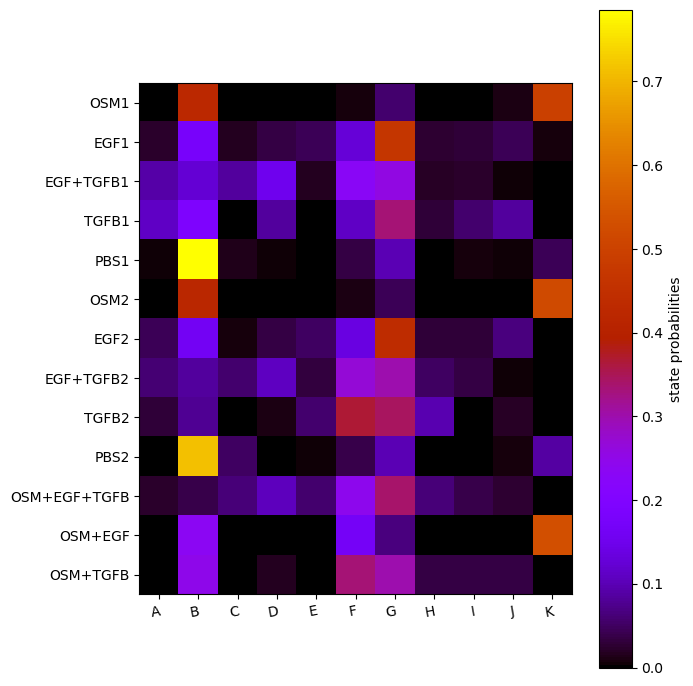

<Figure size 640x480 with 0 Axes>

In [54]:
state_probs = np.zeros((num_trajModSet, n_states))
fl = 72 # 18 hrs
fu = 120 # 30 hrs
#fu = nframes
cell_states = clusters_minima
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0]
for i in range(num_trajModSet):
    indstm = inds_conditions[i]
    indstwm = np.intersect1d(indstm, indstw)
    #x0 = embedTraj_feat[indstwm, :]
    x0 = Xpcat[indstwm, :]
    indc0 = stateSet[clusters_minima.assign(x0)]
    statesc, counts = np.unique(indc0, return_counts = True)
    state_probs[i, statesc] = counts/np.sum(counts)

state_order = np.arange(n_states).astype(int)

plt.clf()
plt.figure(figsize = (7, 7))
plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
cbar = plt.colorbar()
cbar.set_label('state probabilities')

# We want to show all ticks...
ax = plt.gca()
ax.set_yticks(np.arange(len(tmSet)))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(tmSet)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=10, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.savefig('stateprobs_'+figid+'_nS_'+str(nstates)+'.png')
np.savetxt('stateprobs_'+figid+'_nS_'+str(nstates)+'.dat', state_probs[:, state_order])
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize = (7, 6))
nbins = 100
prob1, xedges1, yedges1 = np.histogram2d(embedTraj_feat[:, 0], embedTraj_feat[:, 1], bins=nbins, density=True)
prob1 = scipy.ndimage.gaussian_filter(prob1, sigma=2)
xx1, yy1 = np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1], .5*yedges1[1:]+.5*yedges1[0:-1])
pts = np.array([xx1.flatten(), yy1.flatten()]).T
indpts = clusters_minima.assign(pts)
states = stateSet[indpts]
states = states[prob1.flatten() > np.min(prob1[prob1 > 0])]
pts = pts[prob1.flatten() > np.min(prob1[prob1 > 0]), :]
plt.contourf(xx1, yy1, prob1.T, cmap=plt.cm.gray_r, levels=20, alpha=.3)
plt.scatter(pts[:, 0], pts[:, 1], s=10, c=states, cmap=plt.cm.jet, marker='.', alpha=0.5)
plt.scatter(clusters_minima.clustercenters[:, 0], clusters_minima.clustercenters[:, 1],
            s = 100, c = stateSet, cmap = plt.cm.jet)

for istate in range(n_states):
    plt.text(state_centers_minima[istate, 0], state_centers_minima[istate, 1], str(state_labels[istate]))

plt.pause(.1)
plt.tight_layout()
plt.savefig('kineticstates_'+figid+'_nS_'+str(nstates)+'.png')

In [ ]:
states_x = stateSet[cell_states.assign(embedTraj_feat)]
inds_states = [None]*n_states
for i in range(n_states):
    indstate = np.where(states_x == i)[0]
    inds_states[i] = indstate

vset = Xpcat[:, -3]

plt.clf()
plt.figure(figsize = (8, 7))
ax = plt.gca()

for i in range(n_states):
    ii = state_order[i]
    vplot = ax.violinplot(vset[inds_states[ii]], positions=[i+1], 
                          showmeans=True, showextrema=False) # quantiles=[.05,.95])
    vplot['cmeans'].set_color('black')
    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        #pc.set_edgecolor('black')
        #pc.set_alpha(1)
    plt.pause(.1)

ax.set_xticks(range(1, n_states + 1))
ax.set_xticklabels(np.array(state_labels)[state_order])
#plt.ylabel('log2(nuc/cyto cc-ratio)')
#plt.ylabel(r'cell-cell local alignment $\langle \hat{v}_1 \cdot \hat{v}_2 \rangle$')
#plt.ylabel('speed (z-score)')
plt.ylabel('speed (z-score)')
plt.xlabel('states')
plt.pause(.1)
plt.tight_layout()
plt.savefig('speed_'+figid+'.png')

In [ ]:
from adjustText import adjust_text

plt.clf()
istate = 3
indcells_traj = inds_states[istate]
indmodels = indtreatment_traj[indcells_traj]
indcells_model = cellinds1_traj[indcells_traj]
#for ic in [50, 100, 150, 200]: # range(indcells_traj.size)
for ic in range(0, indcells_traj.size, 50):
    celltraj = self.get_cell_trajectory(indcells_model[ic])
    self.visual = True
    self.show_cells(celltraj)
    plt.pause(1)
    plt.tight_layout()
    plt.savefig('cell'+str(ic)+'_state'+str(istate)+'_'+figid+'.png')

In [ ]:
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
nstates_initial = nstates_initial
def get_kineticstates(self, nstates_initial, P = None, clusters_minima = None,
                      pcut_final = 0.01, random_state = 0, ncomp = 15):
    if P is None:
        print('input transition matrix')
        return
    if clusters_minima is None:
        clusters_minima = self.clusterst
    stateCenters = clusters_minima.clustercenters
    nstates_good = 0
    nstates = nstates_initial
    #silhouette_scores = []
    #nClusters = []
    #plt.clf()
    #plt.figure(figsize = (6, 5))
    while nstates_good < nstates_initial and nstates < 5*nstates_initial: 
        H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
        w, v = np.linalg.eig(H) # Find Eigen Values and Eigen vectors of transition matrix 
        w = np.real(w)
        indsort = np.argsort(w)
        w = w[indsort] # Eigen Values
        v = v[:, indsort] # Eigen Vectors
        vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
        vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
        vkin = np.append(vr, vi, axis=1)
        ############################ KMeans from deeptime #########################
        #clusters_v = KMeans(n_clusters=nstates, init_strategy='kmeans++', max_iter=1000).fit(vkin).fetch_model()
        #stateSet = clusters_v.transform(vkin)
        ############################ KMeans from sklearn ##########################
        clusters_v = KMeans(n_clusters = nstates, init = 'k-means++', n_init = 20000, max_iter = 1000)
        clusters_v.fit(vkin)
        stateSet = clusters_v.labels_
        ######### Examine how many n_clusters aka nstates better represent ########
        #labels_s = clusters_v.predict(vkin)
        #score = silhouette_score(vkin, labels_s)
        #silhouette_scores.append(score)
        state_center_minima = np.zeros((nstates, neigen))
        for i in range(nstates):
            indstate = np.where(stateSet == i)[0]
            state_center_minima[i, :] = np.mean(clusters_minima.clustercenters[indstate, :], axis=0)
        state_probs = np.zeros((num_trajModSet, nstates))
        for i in range(num_trajModSet):
            indstm = inds_conditions[i]
            #x0 = embedTraj_feat[indstm, :]
            x0 = Xpcat[indstm, :]
            indc0 = stateSet[clusters_minima.assign(x0)]
            statesc, counts = np.unique(indc0, return_counts=True)
            state_probs[i, statesc] = counts/np.sum(counts)
        state_tprobs = np.sum(state_probs, axis=0)/num_trajModSet
        print("Transition probabilities of", nstates, "states: ",np.sort(state_tprobs))
        # nstates_good: If transition probabilities of cell states are higher than set probability cutoff
        nstates_good = np.sum(state_tprobs > pcut_final)
        print(nstates, "initial states,", nstates_good, "final (Good) states")
        #nClusters.append(nstates)
        nstates = nstates + 1
    pcut = np.sort(state_tprobs)[-(nstates_initial)] # nstates
    states_plow = np.where(state_tprobs < pcut)[0] # states with low probabilities
    ################# Remove/clean states with low probabilities ####################
    for i in states_plow:
        indstate = np.where(stateSet == i)[0]
        for imin in indstate:
            dists = wctm.get_dmat(np.array([stateCenters[imin, :]]), stateCenters)[0]
            dists[indstate] = np.inf
            ireplace = np.argmin(dists)
            stateSet[imin] = stateSet[ireplace]
    slabels, counts = np.unique(stateSet, return_counts=True)
    s = 0
    stateSet_clean = np.zeros_like(stateSet)
    for slabel in slabels:
        indstate = np.where(stateSet == slabel)[0]
        stateSet_clean[indstate] = s
        s = s + 1
    stateSet = stateSet_clean
    """
    # Plot Silhouette Scores 
    plt.plot(nClusters, silhouette_scores)
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig('silhouette_scores_'+figid+'_'+str(nstates)+'.png') 
    """
    return stateSet, nstates

In [ ]:
get_kstates = True
stateCenters = clusters_minima.clustercenters

if get_kstates:
    stateSet, nstates = get_kineticstates(wctm, nstates_initial, P=P, 
                                          clusters_minima = clusters_minima, pcut_final=.02)
    objFile = 'stateSet_'+figid+'_nS'+str(nstates)+'.joblib'
    states_object = [clusters_minima, stateSet]
    with open(objFile, 'wb') as fpStates:
        dump(states_object, fpStates, compress = 'zlib')
else:
    objFile = 'stateSet_'+figid+'_nS'+str(nstates_initial)+'.joblib'
    with open(objFile, 'rb') as fpStates:
        states_object = load(fpStates)
    clusters_minima = states_object[0]
    stateSet = states_object[1]
plt.close('all')